In [1]:
import pandas as pd
import numpy as np
import os
import time
import collections


#import matplot.lib
## Save Model
import joblib
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
assert gensim.models.doc2vec.FAST_VERSION > -1 #parallelize doc2vec
from gensim.utils import simple_preprocess

In [2]:
#Dask
import dask.dataframe as dd
from dask.distributed import Client
from dask import delayed
client = Client()  # start distributed scheduler locally.  Launch dashboard

client

Client Scheduler: tcp://127.0.0.1:57864 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 16 Memory: 34.31 GB


In [2]:
#os.chdir('Patent Claims')

os.chdir('D:\Datasets')
#fname = os.getcwd()+"\\Doc2vec_Patent_Claims_FINAL_dm_30e"


## EXPERIMENTAL MODEL ##
#EXPERIMENTAL MODEL USES LITIGATION NO LITIGATION AS TAGS NOT PATENT-CLAIM#
#fname = os.getcwd()+"\\Doc2vec_Patent_Claims_FINAL_dm_30e_Lit_tagged"

#model = Doc2Vec.load(fname)

In [330]:
%%time
# Load with out Vectors
ddf= dd.read_csv('claims_vectors_litigation.csv',usecols= ['claim_no','claim_txt','ICL','ICC','litigation'])
# Load with Vectors
#ddf= dd.read_csv('claims_vectors_litigation.csv'])

#df = df.compute()

Wall time: 195 ms


In [331]:
ddf.head()

,claim_no,claim_txt,ICL,ICC,litigation
0,8697278-17,battery comprising interior battery active ele...,106,2,0
1,8697278-1,battery cell casing comprising first casing el...,97,2,0
2,7385756-81,catadioptric projection objective imaging patt...,108,33,0
3,7385756-94,catadioptric projection objective imaging patt...,116,33,0
4,7385756-79,catadioptric projection objective imaging patt...,103,33,0


8216031

In [6]:
%%time
## pair data set down to only primary or (first independent claims)

def prime_claim(df):
    pc_df = df['claim_no'].str.split('-',n = 1, expand = True)

    df['patent'],df['claim_#'] = pc_df[0], pc_df[1]

    df = df.loc[df['claim_#']=='1',:]

    #df.index = df['patent']


    #We no longer need the claim data
    df_tst = df.drop(['claim_no','claim_#'],axis = 1)
    return df_tst

Wall time: 0 ns


In [332]:
## Get First Independent Claims
## Map Partitions in dask is used for speed (may not be needed)
patent_no = ddf['claim_no'].map_partitions(lambda x: x.str.split('-',expand = True)[0],meta=object)
claim_no = ddf['claim_no'].map_partitions(lambda x: x.str.split('-',expand = True)[1],meta=object)

#Assign new columns
ddf = ddf.assign(Patent = patent_no,Claim = claim_no)
#Set index
ddf.index=patent_no
# Drop column unused now
ddf = ddf.drop(['Patent'],axis=1)

# Get all the Primary Claims
ddf = ddf.loc[ddf['Claim']=='1',:]

#Drop unused Column
ddf = ddf.drop(['Claim'],axis=1)


ddf

,claim_no,claim_txt,ICL,ICC,litigation
npartitions=364,,,,,
,object,object,int64,int64,int64
,...,...,...,...,...
...,...,...,...,...,...
,...,...,...,...,...
,...,...,...,...,...


In [8]:
ddf.head()

,claim_no,claim_txt,ICL,ICC,litigation
8697278,8697278-1,battery cell casing comprising first casing el...,97,2,0
7385756,7385756-1,catadioptric projection objective imaging patt...,105,33,0
7387146,7387146-1,"heavy duty tire comprising tread portion, pair...",174,1,0
7387253,7387253-1,system comprising: (a) optical reader includin...,158,10,0
7387278,7387278-1,parachute ripcord pin holding parachute pack c...,40,5,0


In [333]:
%%time
ddf = ddf.compute()

Wall time: 1min 21s


In [10]:
ddf.litigation.value_counts()

0    2907222
1       7526
Name: litigation, dtype: int64

In [309]:
#As we Infer vectors for primary claims let's grab similarities / dissimilarities 
# This will let you get random tagged documents
def tag_claim(df,tag):
    yield TaggedDocument(words=simple_preprocess(df['claim_txt']), 
                             tags=tag)
    
def model_infer_test(df,model):
    start  = time.time()
    sim_pair = pd.DataFrame([])
    i=0
    lit = df.loc[ddf['litigation']==1,:]
    non_lit = df.loc[ddf['litigation']==0,:]
    for index,row in lit.iterrows():
        claim = next(tag_claim(row,row['claim_no'])) #CURRENT MODEL TAGS = PATENT#-CLAIM#
        # infer the vector from random claim
        vector = model.infer_vector(claim.words)
        # get N similar claims from the infered vector
        sims = model.docvecs.most_similar([vector], topn=100) 
        ## Top 100 Similar claims from all trained claims in model
        sims = pd.DataFrame(sims,columns=['claim_no','similarity'])
        ## Append the litigated claim

        sims['sim_claim']=index
        sim_pair = sim_pair.append(sims)
        #print(i)
        if i % 100 == 0:
            end = time.time()
            print(f'Calculated similarity for {i} claims in {end - start} seconds')
        i+=1
    ## top 100 Similar Patent Claims
    ## Merge Similar Patent Claims that have not been litigated
    sim_pair = pd.merge(non_lit,sim_pair,how='inner',on='claim_no')
    #sim_pair = [sim for sim in sim_pair if sim['claim_no'] in non_lit['claim_no']]
    return sim_pair
        

Wall time: 6.98 s


In [312]:
%%time

%time vectors = ddf['claim_txt'].apply((lambda row : calc_vectors(get_tokens(row))))
#%time lit_vectors = tokens.apply((lambda row : calc_vectors(row)))
%time sims = vectors.apply(lambda row : pd.Series(dict(model.docvecs.most_similar([row],topn=2))))
sims.columns=['non_lit_sim','lit_sim']
%time df_vectors = vectors.apply(lambda x : pd.Series(x))



Wall time: 2h 43min 19s


distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:60127 remote=tcp://127.0.0.1:57864>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:60129 remote=tcp://127.0.0.1:57864>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:60130 remote=tcp://127.0.0.1:57864>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:60131 remote=tcp://127.0.0.1:57864>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:60132 remote=tcp://127.0.0.1:57864>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:60138 remote=tcp://127.0.0.1:57864>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:60139 remote=tcp://127.0.0.1:57864>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:60140 remote=tcp://127.0.0.1:57864>
distribu

Wall time: 17min 50s


distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:60151 remote=tcp://127.0.0.1:57864>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:60152 remote=tcp://127.0.0.1:57864>


Wall time: 7min 47s
Wall time: 3h 8min 58s


In [334]:
%%time
# Merge the similarities witht the Claim Vectors
df_sim_vector = pd.merge(sims,df_vectors,how='inner',left_index=True,right_index=True)
#Merge everything
ddf = pd.merge(ddf,df_sim_vector,how='inner',left_index=True,right_index=True)


Wall time: 4.65 s


In [335]:
ddf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2914748 entries, 8697278 to 8794966
Columns: 107 entries, claim_no to 99
dtypes: float32(100), float64(2), int64(3), object(2)
memory usage: 1.3+ GB


In [311]:
%%time
ddf_sim = model_infer_test(ddf,model)


Calculated similarity for 0 claims in 0.8497745990753174 seconds
Calculated similarity for 100 claims in 1.50537109375 seconds
Calculated similarity for 200 claims in 2.155963659286499 seconds
Calculated similarity for 300 claims in 2.763516664505005 seconds
Calculated similarity for 400 claims in 3.4231176376342773 seconds
Calculated similarity for 500 claims in 4.081717252731323 seconds
Calculated similarity for 600 claims in 4.68726921081543 seconds
Calculated similarity for 700 claims in 5.306832790374756 seconds


KeyboardInterrupt: 

In [223]:
#Test code for running experimental model


In [13]:
%%time
#list of all claims that will be classified
mrg = pd.DataFrame(sims.claim_no.unique()).append(pd.DataFrame(sims.sim_claim.unique())+"-1")
mrg.columns=['claim_no']

#get litigation and similar non-litigation claims
df_gbd = pd.merge(ddf,mrg,how='inner',on='claim_no')
df_gbd.head()

Wall time: 1.4 s


In [14]:
df_gbd.loc[df_gbd['litigation']==0,:]

,claim_no,claim_txt,ICL,ICC,litigation
0,6829356-1,method enabling devices securely regenerate us...,202,30,0
1,6831309-1,unipolar photodiode comprising:a carrier trave...,70,5,0
2,6833762-1,transimpendance amplifier comprising:a single ...,58,3,0
3,8031203-1,image processing apparatus comprising: first c...,141,3,0
4,8031654-1,apparatus use allocating resource wireless com...,114,10,0
5,6266273-1,non-volatile memory system comprising:an array...,42,1,0
6,8032340-1,"method modeling behavior process plant, compri...",138,4,0
7,8032353-1,"method managing communications bridged, via co...",165,3,0
8,6840488-1,furniture support carpet protection apparatus ...,144,22,0
9,6841232-1,reinforced wallboard core comprising: water; d...,56,5,0


In [248]:
## Make Vectors from the above dataset

def calc_vectors(tokens):
    return model.infer_vector((tokens),steps=20)
def get_tokens(col):
    tokens =gensim.utils.simple_preprocess(col)
    return tokens


In [16]:
%%time
%time tokens = df_gbd['claim_txt'].apply((lambda row : get_tokens(row)))
%time vectors = tokens.apply((lambda row : calc_vectors(row)))
%time df_vectors = vectors.apply(lambda x : pd.Series(x))



Wall time: 28.4 s
Wall time: 9min 3s
Wall time: 25.2 s
Wall time: 9min 57s


In [17]:
%%time
df_vectors['claim_no']=df_gbd['claim_no']

Wall time: 6.01 ms


In [18]:
%time df_gbd = pd.merge(df_gbd,df_vectors,how='inner',on='claim_no')

Wall time: 295 ms


In [20]:
df_gbd.drop('claim_txt',axis=1,inplace=True)
#free up memory
del ddf

In [21]:
df_gbd.head()

,claim_no,ICL,ICC,litigation,0,1,2,3,4,5,...,90,91,92,93,94,95,96,97,98,99
0,6829356-1,202,30,0,-1.642752,-1.742979,0.410437,-2.058042,-1.180383,-1.122285,...,0.900530,1.446652,2.394913,-1.334146,0.456000,1.407904,-1.642250,1.321697,-1.853387,1.157247
1,6831309-1,70,5,0,2.000060,-0.227716,-0.629473,0.915063,1.938106,-0.902107,...,0.511128,-1.020436,0.378141,-0.355949,-0.466579,0.734007,0.019068,1.017143,0.847043,1.105414
2,6833762-1,58,3,0,0.421782,-0.303164,-0.170216,-0.375787,0.484330,-0.070391,...,-0.328015,1.009738,-0.108919,-0.131952,-0.247243,-0.668554,0.426649,-0.670840,-0.345314,0.604490
3,8031203-1,141,3,0,-0.675720,1.440410,2.054774,0.921870,1.431771,-1.347362,...,0.426724,0.506884,1.200557,1.457850,-0.698446,2.567523,-1.093384,-2.045717,-1.390943,1.377452
4,8031654-1,114,10,0,0.590546,-1.322688,-1.078653,0.866930,1.274311,-0.268922,...,-1.130539,0.087429,-0.008749,-1.200950,0.294773,2.331678,0.531936,-1.375039,-1.265958,-0.140881


In [3]:
###### START HERE FOR CLASSIFICATION
## Save this Dataset so we don't have to repeat work.
#df_gbd.to_csv('similar_primary_claims_final.csv')
## uncomment to load data if redoing classification
df_gbd=pd.read_csv('similar_primary_claims_final.csv')

### SAVING EXPERIMENTAL MODEL ###
#ddf.to_csv('primary_claim_litigation_similarity.csv')


In [5]:
df_gbd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205501 entries, 0 to 205500
Columns: 105 entries, Unnamed: 0 to 99
dtypes: float64(100), int64(4), object(1)
memory usage: 164.6+ MB


In [7]:
df_gbd['litigation'].value_counts()

0    197975
1      7526
Name: litigation, dtype: int64

In [10]:
df_gbd['litigation'].value_counts(normalize=True)

0    0.963377
1    0.036623
Name: litigation, dtype: float64

In [315]:
%%time
### Classification
import xgboost as xgb
from sklearn.model_selection import train_test_split 


Wall time: 1.17 s


In [319]:
### Here is the results from the previous models
# This includes ALL independent claims
models_names = ['ICL_ICC_100F','ICL_100F','ICC_100F','100F','ICL_ICC']
non_lit = [100-.3645,100-.3645,100-.3645,100-.3645,100-.3645]
lit = [.3645,.3645,.3645,.3645,.3645]
RMSE = [.3142,.3267,.3138,.3283,.3490]
results_ac = pd.DataFrame({
    'model':models_names,
    '% non-lit claims' : non_lit,
    '% lit claims': lit,
    'RMSE':[x/100 for x in RMSE],
    '% predicted':[(x-y) for x,y in zip(lit,RMSE)]})

In [320]:
## Test Results From Test Set 1
results_ac

,model,% non-lit claims,% lit claims,RMSE,% predicted
0,ICL_ICC_100F,99.6355,0.3645,0.003142,0.0503
1,ICL_100F,99.6355,0.3645,0.003267,0.0378
2,ICC_100F,99.6355,0.3645,0.003138,0.0507
3,100F,99.6355,0.3645,0.003283,0.0362
4,ICL_ICC,99.6355,0.3645,0.003490,0.0155


In [101]:
df_gbd   #ICL_ICC_100F
df_gbd_1 = df_gbd.drop('ICC',axis=1)#ICL_100F
df_gbd_2 = df_gbd.drop('ICL',axis=1)#ICC_100F
df_gbd_3 = df_gbd.drop(['ICC','ICL'],axis=1)#100F
df_gbd_4 = df_gbd.loc[:,'claim_no':'litigation'] #ICL_ICC

In [254]:
## Run all the models and gather results for all models
## SOME OF THIS CODE IS EXTRANEOUS however I initially did this part by hand
run = [0,1,2,3,4]
# Data for feature comparrison
models  = [df_gbd, df_gbd_1,df_gbd_2,df_gbd_3,df_gbd_4]
models_names = ['ICL_ICC_100F','ICL_100F','ICC_100F','100F','ICL_ICC']
num_round = 5000
# Params for models
param = {'objective'   : 'binary:logistic', # Specify binary classification
         'eta'         : .5,
         'max_depth'   : 8,
         'predictor'   : 'gpu_predictor',
         #'verbosity'   : 3,
         'tree_method' : 'gpu_hist', # Use GPU accelerated algorithm
         'random_state': 42
        }
results_01 = pd.DataFrame({})
for i in run:
    #population of litigated to non litigated cases (it's the same every time)
    population = models[run[i]]['litigation'].value_counts(normalize=True)
    y = models[run[i]]['litigation']
    X = models[run[i]].drop(['litigation','claim_no'],axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30,random_state=42)

    #free up memory
    del y,X

    # Convert input data from numpy to XGBoost format
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    #again to conserve memory
    del X_train, X_test, y_train, y_test
    
    gpu_res = {} # Store accuracy result
    tmp = time.time()
    # Train model
    tst_model = xgb.train(param, dtrain, num_round, evals=[(dtest, 'test')], evals_result=gpu_res)
    print("GPU Training Time: %s seconds" % (str(time.time() - tmp)))

    #save model
    joblib.dump(tst_model, 'PC_'+models_names[run[i]]) 
    ## RMSE
    error = float(tst_model.eval(dtest).split(':')[1])
    
    results_01 = results_01.append(pd.DataFrame({
    'model':models_names[run[i]],
    '% non-lit claims':population[0]*100,
    '% lit claims':population[1]*100,
    '% RMSE':error*100,
    '% predicted':(population[1]-error)*100,
    'hyp' : 'sim_lit_claim'
    },index=[run[i]]))
results_01
results_01.to_csv('prime_claim_model_results.csv')
    

[0]	test-error:0.035717
[1]	test-error:0.035409
[2]	test-error:0.035214
[3]	test-error:0.035247
[4]	test-error:0.035295
[5]	test-error:0.035441
[6]	test-error:0.035539
[7]	test-error:0.035474
[8]	test-error:0.035604
[9]	test-error:0.035669
[10]	test-error:0.035766
[11]	test-error:0.035879
[12]	test-error:0.036058
[13]	test-error:0.036188
[14]	test-error:0.03635
[15]	test-error:0.036252
[16]	test-error:0.036236
[17]	test-error:0.036252
[18]	test-error:0.036415
[19]	test-error:0.036496
[20]	test-error:0.036447
[21]	test-error:0.03635
[22]	test-error:0.036463
[23]	test-error:0.036301
[24]	test-error:0.036463
[25]	test-error:0.036415
[26]	test-error:0.036415
[27]	test-error:0.036544
[28]	test-error:0.036577
[29]	test-error:0.036512
[30]	test-error:0.036512
[31]	test-error:0.036496
[32]	test-error:0.036382
[33]	test-error:0.036301
[34]	test-error:0.036269
[35]	test-error:0.036447
[36]	test-error:0.036431
[37]	test-error:0.036528
[38]	test-error:0.036301
[39]	test-error:0.036285
[40]	test-er

[321]	test-error:0.035377
[322]	test-error:0.03536
[323]	test-error:0.03536
[324]	test-error:0.035377
[325]	test-error:0.03536
[326]	test-error:0.035377
[327]	test-error:0.035377
[328]	test-error:0.035377
[329]	test-error:0.035377
[330]	test-error:0.035377
[331]	test-error:0.035377
[332]	test-error:0.035377
[333]	test-error:0.035377
[334]	test-error:0.035377
[335]	test-error:0.035377
[336]	test-error:0.03536
[337]	test-error:0.035344
[338]	test-error:0.03536
[339]	test-error:0.035344
[340]	test-error:0.035344
[341]	test-error:0.035344
[342]	test-error:0.035344
[343]	test-error:0.035344
[344]	test-error:0.035344
[345]	test-error:0.035344
[346]	test-error:0.035344
[347]	test-error:0.035328
[348]	test-error:0.035328
[349]	test-error:0.035344
[350]	test-error:0.035344
[351]	test-error:0.035344
[352]	test-error:0.03536
[353]	test-error:0.035328
[354]	test-error:0.035328
[355]	test-error:0.035328
[356]	test-error:0.035312
[357]	test-error:0.035328
[358]	test-error:0.035312
[359]	test-error:0

[638]	test-error:0.035312
[639]	test-error:0.035295
[640]	test-error:0.035312
[641]	test-error:0.035312
[642]	test-error:0.035312
[643]	test-error:0.035312
[644]	test-error:0.035295
[645]	test-error:0.035295
[646]	test-error:0.035295
[647]	test-error:0.035295
[648]	test-error:0.035295
[649]	test-error:0.035295
[650]	test-error:0.035295
[651]	test-error:0.035295
[652]	test-error:0.035295
[653]	test-error:0.035295
[654]	test-error:0.035295
[655]	test-error:0.035279
[656]	test-error:0.035279
[657]	test-error:0.035279
[658]	test-error:0.035279
[659]	test-error:0.035279
[660]	test-error:0.035279
[661]	test-error:0.035279
[662]	test-error:0.035279
[663]	test-error:0.035279
[664]	test-error:0.035295
[665]	test-error:0.035295
[666]	test-error:0.035295
[667]	test-error:0.035295
[668]	test-error:0.035295
[669]	test-error:0.035295
[670]	test-error:0.035295
[671]	test-error:0.035295
[672]	test-error:0.035295
[673]	test-error:0.035279
[674]	test-error:0.035295
[675]	test-error:0.035295
[676]	test-e

[954]	test-error:0.035247
[955]	test-error:0.035263
[956]	test-error:0.035247
[957]	test-error:0.035263
[958]	test-error:0.035263
[959]	test-error:0.035263
[960]	test-error:0.035263
[961]	test-error:0.035231
[962]	test-error:0.035231
[963]	test-error:0.035247
[964]	test-error:0.035247
[965]	test-error:0.035247
[966]	test-error:0.035231
[967]	test-error:0.035231
[968]	test-error:0.035231
[969]	test-error:0.035231
[970]	test-error:0.035231
[971]	test-error:0.035231
[972]	test-error:0.035231
[973]	test-error:0.035231
[974]	test-error:0.035247
[975]	test-error:0.035247
[976]	test-error:0.035247
[977]	test-error:0.035247
[978]	test-error:0.035247
[979]	test-error:0.035263
[980]	test-error:0.035247
[981]	test-error:0.035247
[982]	test-error:0.035263
[983]	test-error:0.035247
[984]	test-error:0.035231
[985]	test-error:0.035231
[986]	test-error:0.035247
[987]	test-error:0.035231
[988]	test-error:0.035231
[989]	test-error:0.035231
[990]	test-error:0.035263
[991]	test-error:0.035263
[992]	test-e

[1260]	test-error:0.035328
[1261]	test-error:0.035328
[1262]	test-error:0.035328
[1263]	test-error:0.035312
[1264]	test-error:0.035312
[1265]	test-error:0.035312
[1266]	test-error:0.035312
[1267]	test-error:0.035328
[1268]	test-error:0.035328
[1269]	test-error:0.035328
[1270]	test-error:0.035328
[1271]	test-error:0.035328
[1272]	test-error:0.035328
[1273]	test-error:0.035328
[1274]	test-error:0.035312
[1275]	test-error:0.035328
[1276]	test-error:0.035328
[1277]	test-error:0.035328
[1278]	test-error:0.035312
[1279]	test-error:0.035312
[1280]	test-error:0.035312
[1281]	test-error:0.035312
[1282]	test-error:0.035312
[1283]	test-error:0.035328
[1284]	test-error:0.035312
[1285]	test-error:0.035328
[1286]	test-error:0.035328
[1287]	test-error:0.035328
[1288]	test-error:0.035312
[1289]	test-error:0.035312
[1290]	test-error:0.035312
[1291]	test-error:0.035312
[1292]	test-error:0.035312
[1293]	test-error:0.035312
[1294]	test-error:0.035312
[1295]	test-error:0.035312
[1296]	test-error:0.035312
[

[1564]	test-error:0.035295
[1565]	test-error:0.035295
[1566]	test-error:0.035312
[1567]	test-error:0.035295
[1568]	test-error:0.035295
[1569]	test-error:0.035312
[1570]	test-error:0.035295
[1571]	test-error:0.035295
[1572]	test-error:0.035295
[1573]	test-error:0.035295
[1574]	test-error:0.035295
[1575]	test-error:0.035295
[1576]	test-error:0.035312
[1577]	test-error:0.035312
[1578]	test-error:0.035295
[1579]	test-error:0.035295
[1580]	test-error:0.035312
[1581]	test-error:0.035312
[1582]	test-error:0.035295
[1583]	test-error:0.035295
[1584]	test-error:0.035295
[1585]	test-error:0.035279
[1586]	test-error:0.035295
[1587]	test-error:0.035279
[1588]	test-error:0.035295
[1589]	test-error:0.035295
[1590]	test-error:0.035295
[1591]	test-error:0.035295
[1592]	test-error:0.035295
[1593]	test-error:0.035295
[1594]	test-error:0.035312
[1595]	test-error:0.035312
[1596]	test-error:0.035312
[1597]	test-error:0.035295
[1598]	test-error:0.035295
[1599]	test-error:0.035295
[1600]	test-error:0.035295
[

[1868]	test-error:0.035295
[1869]	test-error:0.035295
[1870]	test-error:0.035312
[1871]	test-error:0.035312
[1872]	test-error:0.035312
[1873]	test-error:0.035312
[1874]	test-error:0.035312
[1875]	test-error:0.035312
[1876]	test-error:0.035312
[1877]	test-error:0.035328
[1878]	test-error:0.035312
[1879]	test-error:0.035312
[1880]	test-error:0.035312
[1881]	test-error:0.035312
[1882]	test-error:0.035295
[1883]	test-error:0.035295
[1884]	test-error:0.035295
[1885]	test-error:0.035295
[1886]	test-error:0.035295
[1887]	test-error:0.035295
[1888]	test-error:0.035312
[1889]	test-error:0.035295
[1890]	test-error:0.035312
[1891]	test-error:0.035295
[1892]	test-error:0.035295
[1893]	test-error:0.035295
[1894]	test-error:0.035295
[1895]	test-error:0.035312
[1896]	test-error:0.035312
[1897]	test-error:0.035312
[1898]	test-error:0.035312
[1899]	test-error:0.035295
[1900]	test-error:0.035295
[1901]	test-error:0.035295
[1902]	test-error:0.035295
[1903]	test-error:0.035295
[1904]	test-error:0.035295
[

[2172]	test-error:0.035295
[2173]	test-error:0.035295
[2174]	test-error:0.035295
[2175]	test-error:0.035295
[2176]	test-error:0.035295
[2177]	test-error:0.035295
[2178]	test-error:0.035279
[2179]	test-error:0.035279
[2180]	test-error:0.035279
[2181]	test-error:0.035279
[2182]	test-error:0.035279
[2183]	test-error:0.035279
[2184]	test-error:0.035279
[2185]	test-error:0.035279
[2186]	test-error:0.035279
[2187]	test-error:0.035279
[2188]	test-error:0.035279
[2189]	test-error:0.035279
[2190]	test-error:0.035279
[2191]	test-error:0.035279
[2192]	test-error:0.035279
[2193]	test-error:0.035279
[2194]	test-error:0.035279
[2195]	test-error:0.035279
[2196]	test-error:0.035279
[2197]	test-error:0.035279
[2198]	test-error:0.035279
[2199]	test-error:0.035279
[2200]	test-error:0.035279
[2201]	test-error:0.035279
[2202]	test-error:0.035279
[2203]	test-error:0.035279
[2204]	test-error:0.035279
[2205]	test-error:0.035279
[2206]	test-error:0.035279
[2207]	test-error:0.035279
[2208]	test-error:0.035279
[

[2476]	test-error:0.035312
[2477]	test-error:0.035312
[2478]	test-error:0.035295
[2479]	test-error:0.035312
[2480]	test-error:0.035295
[2481]	test-error:0.035295
[2482]	test-error:0.035295
[2483]	test-error:0.035295
[2484]	test-error:0.035295
[2485]	test-error:0.035295
[2486]	test-error:0.035295
[2487]	test-error:0.035295
[2488]	test-error:0.035295
[2489]	test-error:0.035295
[2490]	test-error:0.035295
[2491]	test-error:0.035295
[2492]	test-error:0.035295
[2493]	test-error:0.035295
[2494]	test-error:0.035295
[2495]	test-error:0.035279
[2496]	test-error:0.035279
[2497]	test-error:0.035295
[2498]	test-error:0.035295
[2499]	test-error:0.035295
[2500]	test-error:0.035295
[2501]	test-error:0.035295
[2502]	test-error:0.035295
[2503]	test-error:0.035295
[2504]	test-error:0.035295
[2505]	test-error:0.035295
[2506]	test-error:0.035295
[2507]	test-error:0.035295
[2508]	test-error:0.035295
[2509]	test-error:0.035295
[2510]	test-error:0.035295
[2511]	test-error:0.035295
[2512]	test-error:0.035295
[

[2780]	test-error:0.035295
[2781]	test-error:0.035295
[2782]	test-error:0.035295
[2783]	test-error:0.035295
[2784]	test-error:0.035295
[2785]	test-error:0.035295
[2786]	test-error:0.035295
[2787]	test-error:0.035295
[2788]	test-error:0.035295
[2789]	test-error:0.035295
[2790]	test-error:0.035295
[2791]	test-error:0.035295
[2792]	test-error:0.035295
[2793]	test-error:0.035295
[2794]	test-error:0.035295
[2795]	test-error:0.035295
[2796]	test-error:0.035295
[2797]	test-error:0.035295
[2798]	test-error:0.035295
[2799]	test-error:0.035295
[2800]	test-error:0.035295
[2801]	test-error:0.035295
[2802]	test-error:0.035295
[2803]	test-error:0.035295
[2804]	test-error:0.035295
[2805]	test-error:0.035295
[2806]	test-error:0.035295
[2807]	test-error:0.035295
[2808]	test-error:0.035295
[2809]	test-error:0.035295
[2810]	test-error:0.035295
[2811]	test-error:0.035295
[2812]	test-error:0.035295
[2813]	test-error:0.035295
[2814]	test-error:0.035295
[2815]	test-error:0.035295
[2816]	test-error:0.035295
[

[3084]	test-error:0.035295
[3085]	test-error:0.035295
[3086]	test-error:0.035295
[3087]	test-error:0.035295
[3088]	test-error:0.035295
[3089]	test-error:0.035295
[3090]	test-error:0.035295
[3091]	test-error:0.035295
[3092]	test-error:0.035295
[3093]	test-error:0.035295
[3094]	test-error:0.035295
[3095]	test-error:0.035295
[3096]	test-error:0.035295
[3097]	test-error:0.035295
[3098]	test-error:0.035295
[3099]	test-error:0.035295
[3100]	test-error:0.035295
[3101]	test-error:0.035295
[3102]	test-error:0.035295
[3103]	test-error:0.035295
[3104]	test-error:0.035295
[3105]	test-error:0.035295
[3106]	test-error:0.035295
[3107]	test-error:0.035295
[3108]	test-error:0.035295
[3109]	test-error:0.035295
[3110]	test-error:0.035295
[3111]	test-error:0.035295
[3112]	test-error:0.035295
[3113]	test-error:0.035295
[3114]	test-error:0.035295
[3115]	test-error:0.035295
[3116]	test-error:0.035295
[3117]	test-error:0.035295
[3118]	test-error:0.035295
[3119]	test-error:0.035295
[3120]	test-error:0.035295
[

[3388]	test-error:0.035263
[3389]	test-error:0.035263
[3390]	test-error:0.035263
[3391]	test-error:0.035263
[3392]	test-error:0.035263
[3393]	test-error:0.035263
[3394]	test-error:0.035263
[3395]	test-error:0.035263
[3396]	test-error:0.035263
[3397]	test-error:0.035263
[3398]	test-error:0.035263
[3399]	test-error:0.035263
[3400]	test-error:0.035263
[3401]	test-error:0.035263
[3402]	test-error:0.035263
[3403]	test-error:0.035263
[3404]	test-error:0.035263
[3405]	test-error:0.035263
[3406]	test-error:0.035263
[3407]	test-error:0.035263
[3408]	test-error:0.035263
[3409]	test-error:0.035263
[3410]	test-error:0.035263
[3411]	test-error:0.035263
[3412]	test-error:0.035263
[3413]	test-error:0.035263
[3414]	test-error:0.035263
[3415]	test-error:0.035263
[3416]	test-error:0.035263
[3417]	test-error:0.035263
[3418]	test-error:0.035263
[3419]	test-error:0.035263
[3420]	test-error:0.035263
[3421]	test-error:0.035263
[3422]	test-error:0.035263
[3423]	test-error:0.035263
[3424]	test-error:0.035263
[

[3692]	test-error:0.035295
[3693]	test-error:0.035295
[3694]	test-error:0.035295
[3695]	test-error:0.035295
[3696]	test-error:0.035279
[3697]	test-error:0.035279
[3698]	test-error:0.035279
[3699]	test-error:0.035279
[3700]	test-error:0.035279
[3701]	test-error:0.035279
[3702]	test-error:0.035295
[3703]	test-error:0.035279
[3704]	test-error:0.035295
[3705]	test-error:0.035295
[3706]	test-error:0.035295
[3707]	test-error:0.035295
[3708]	test-error:0.035295
[3709]	test-error:0.035295
[3710]	test-error:0.035295
[3711]	test-error:0.035279
[3712]	test-error:0.035295
[3713]	test-error:0.035263
[3714]	test-error:0.035279
[3715]	test-error:0.035263
[3716]	test-error:0.035263
[3717]	test-error:0.035279
[3718]	test-error:0.035263
[3719]	test-error:0.035295
[3720]	test-error:0.035295
[3721]	test-error:0.035295
[3722]	test-error:0.035295
[3723]	test-error:0.035295
[3724]	test-error:0.035295
[3725]	test-error:0.035295
[3726]	test-error:0.035295
[3727]	test-error:0.035295
[3728]	test-error:0.035295
[

[3996]	test-error:0.035279
[3997]	test-error:0.035279
[3998]	test-error:0.035279
[3999]	test-error:0.035263
[4000]	test-error:0.035263
[4001]	test-error:0.035263
[4002]	test-error:0.035263
[4003]	test-error:0.035263
[4004]	test-error:0.035247
[4005]	test-error:0.035247
[4006]	test-error:0.035263
[4007]	test-error:0.035263
[4008]	test-error:0.035263
[4009]	test-error:0.035263
[4010]	test-error:0.035247
[4011]	test-error:0.035263
[4012]	test-error:0.035263
[4013]	test-error:0.035263
[4014]	test-error:0.035247
[4015]	test-error:0.035247
[4016]	test-error:0.035247
[4017]	test-error:0.035247
[4018]	test-error:0.035247
[4019]	test-error:0.035247
[4020]	test-error:0.035247
[4021]	test-error:0.035263
[4022]	test-error:0.035263
[4023]	test-error:0.035263
[4024]	test-error:0.035263
[4025]	test-error:0.035263
[4026]	test-error:0.035247
[4027]	test-error:0.035247
[4028]	test-error:0.035247
[4029]	test-error:0.035247
[4030]	test-error:0.035247
[4031]	test-error:0.035247
[4032]	test-error:0.035247
[

[4300]	test-error:0.035279
[4301]	test-error:0.035279
[4302]	test-error:0.035263
[4303]	test-error:0.035279
[4304]	test-error:0.035279
[4305]	test-error:0.035279
[4306]	test-error:0.035279
[4307]	test-error:0.035279
[4308]	test-error:0.035263
[4309]	test-error:0.035263
[4310]	test-error:0.035263
[4311]	test-error:0.035263
[4312]	test-error:0.035263
[4313]	test-error:0.035263
[4314]	test-error:0.035263
[4315]	test-error:0.035263
[4316]	test-error:0.035263
[4317]	test-error:0.035263
[4318]	test-error:0.035263
[4319]	test-error:0.035263
[4320]	test-error:0.035263
[4321]	test-error:0.035263
[4322]	test-error:0.035263
[4323]	test-error:0.035247
[4324]	test-error:0.035263
[4325]	test-error:0.035263
[4326]	test-error:0.035247
[4327]	test-error:0.035263
[4328]	test-error:0.035279
[4329]	test-error:0.035279
[4330]	test-error:0.035279
[4331]	test-error:0.035279
[4332]	test-error:0.035279
[4333]	test-error:0.035279
[4334]	test-error:0.035279
[4335]	test-error:0.035279
[4336]	test-error:0.035279
[

[4604]	test-error:0.035247
[4605]	test-error:0.035247
[4606]	test-error:0.035247
[4607]	test-error:0.035247
[4608]	test-error:0.035247
[4609]	test-error:0.035247
[4610]	test-error:0.035247
[4611]	test-error:0.035247
[4612]	test-error:0.035247
[4613]	test-error:0.035247
[4614]	test-error:0.035247
[4615]	test-error:0.035247
[4616]	test-error:0.035247
[4617]	test-error:0.035247
[4618]	test-error:0.035247
[4619]	test-error:0.035247
[4620]	test-error:0.035247
[4621]	test-error:0.035247
[4622]	test-error:0.035247
[4623]	test-error:0.035247
[4624]	test-error:0.035247
[4625]	test-error:0.035247
[4626]	test-error:0.035247
[4627]	test-error:0.035247
[4628]	test-error:0.035247
[4629]	test-error:0.035247
[4630]	test-error:0.035247
[4631]	test-error:0.035247
[4632]	test-error:0.035247
[4633]	test-error:0.035247
[4634]	test-error:0.035247
[4635]	test-error:0.035247
[4636]	test-error:0.035247
[4637]	test-error:0.035247
[4638]	test-error:0.035247
[4639]	test-error:0.035247
[4640]	test-error:0.035247
[

[4908]	test-error:0.035231
[4909]	test-error:0.035231
[4910]	test-error:0.035231
[4911]	test-error:0.035231
[4912]	test-error:0.035231
[4913]	test-error:0.035231
[4914]	test-error:0.035231
[4915]	test-error:0.035231
[4916]	test-error:0.035231
[4917]	test-error:0.035231
[4918]	test-error:0.035231
[4919]	test-error:0.035231
[4920]	test-error:0.035231
[4921]	test-error:0.035231
[4922]	test-error:0.035231
[4923]	test-error:0.035231
[4924]	test-error:0.035231
[4925]	test-error:0.035231
[4926]	test-error:0.035231
[4927]	test-error:0.035231
[4928]	test-error:0.035231
[4929]	test-error:0.035231
[4930]	test-error:0.035231
[4931]	test-error:0.035231
[4932]	test-error:0.035231
[4933]	test-error:0.035231
[4934]	test-error:0.035231
[4935]	test-error:0.035231
[4936]	test-error:0.035231
[4937]	test-error:0.035231
[4938]	test-error:0.035231
[4939]	test-error:0.035231
[4940]	test-error:0.035231
[4941]	test-error:0.035231
[4942]	test-error:0.035231
[4943]	test-error:0.035231
[4944]	test-error:0.035231
[

[224]	test-error:0.035344
[225]	test-error:0.035312
[226]	test-error:0.035312
[227]	test-error:0.035295
[228]	test-error:0.035312
[229]	test-error:0.035328
[230]	test-error:0.035344
[231]	test-error:0.035344
[232]	test-error:0.035328
[233]	test-error:0.035295
[234]	test-error:0.035295
[235]	test-error:0.035312
[236]	test-error:0.035295
[237]	test-error:0.035295
[238]	test-error:0.035279
[239]	test-error:0.035279
[240]	test-error:0.035295
[241]	test-error:0.035263
[242]	test-error:0.035279
[243]	test-error:0.035295
[244]	test-error:0.035295
[245]	test-error:0.035279
[246]	test-error:0.035312
[247]	test-error:0.035295
[248]	test-error:0.035295
[249]	test-error:0.035328
[250]	test-error:0.035312
[251]	test-error:0.035295
[252]	test-error:0.035279
[253]	test-error:0.035295
[254]	test-error:0.035295
[255]	test-error:0.035312
[256]	test-error:0.035295
[257]	test-error:0.035295
[258]	test-error:0.035295
[259]	test-error:0.035312
[260]	test-error:0.035312
[261]	test-error:0.035312
[262]	test-e

[540]	test-error:0.035214
[541]	test-error:0.035198
[542]	test-error:0.035198
[543]	test-error:0.035214
[544]	test-error:0.035198
[545]	test-error:0.035198
[546]	test-error:0.035182
[547]	test-error:0.035182
[548]	test-error:0.035182
[549]	test-error:0.035198
[550]	test-error:0.035182
[551]	test-error:0.035182
[552]	test-error:0.035182
[553]	test-error:0.035182
[554]	test-error:0.035182
[555]	test-error:0.035182
[556]	test-error:0.035182
[557]	test-error:0.035182
[558]	test-error:0.035182
[559]	test-error:0.035182
[560]	test-error:0.035182
[561]	test-error:0.035182
[562]	test-error:0.035182
[563]	test-error:0.035182
[564]	test-error:0.035182
[565]	test-error:0.035182
[566]	test-error:0.035182
[567]	test-error:0.035182
[568]	test-error:0.035182
[569]	test-error:0.035182
[570]	test-error:0.035182
[571]	test-error:0.035182
[572]	test-error:0.035182
[573]	test-error:0.035182
[574]	test-error:0.035182
[575]	test-error:0.035182
[576]	test-error:0.035182
[577]	test-error:0.035182
[578]	test-e

[856]	test-error:0.035182
[857]	test-error:0.035182
[858]	test-error:0.035182
[859]	test-error:0.035182
[860]	test-error:0.035182
[861]	test-error:0.035182
[862]	test-error:0.035182
[863]	test-error:0.035182
[864]	test-error:0.035182
[865]	test-error:0.035182
[866]	test-error:0.035182
[867]	test-error:0.035182
[868]	test-error:0.035182
[869]	test-error:0.035182
[870]	test-error:0.035182
[871]	test-error:0.035182
[872]	test-error:0.035182
[873]	test-error:0.035182
[874]	test-error:0.035182
[875]	test-error:0.035182
[876]	test-error:0.035182
[877]	test-error:0.035182
[878]	test-error:0.035182
[879]	test-error:0.035182
[880]	test-error:0.035182
[881]	test-error:0.035182
[882]	test-error:0.035182
[883]	test-error:0.035182
[884]	test-error:0.035182
[885]	test-error:0.035182
[886]	test-error:0.035182
[887]	test-error:0.035182
[888]	test-error:0.035182
[889]	test-error:0.035198
[890]	test-error:0.035198
[891]	test-error:0.035182
[892]	test-error:0.035182
[893]	test-error:0.035182
[894]	test-e

[1165]	test-error:0.035182
[1166]	test-error:0.035182
[1167]	test-error:0.035182
[1168]	test-error:0.035182
[1169]	test-error:0.035182
[1170]	test-error:0.035182
[1171]	test-error:0.035182
[1172]	test-error:0.035182
[1173]	test-error:0.035182
[1174]	test-error:0.035182
[1175]	test-error:0.035182
[1176]	test-error:0.035182
[1177]	test-error:0.035182
[1178]	test-error:0.035182
[1179]	test-error:0.035182
[1180]	test-error:0.035182
[1181]	test-error:0.035182
[1182]	test-error:0.035182
[1183]	test-error:0.035182
[1184]	test-error:0.035182
[1185]	test-error:0.035182
[1186]	test-error:0.035182
[1187]	test-error:0.035182
[1188]	test-error:0.035182
[1189]	test-error:0.035198
[1190]	test-error:0.035182
[1191]	test-error:0.035198
[1192]	test-error:0.035182
[1193]	test-error:0.035182
[1194]	test-error:0.035182
[1195]	test-error:0.035182
[1196]	test-error:0.035182
[1197]	test-error:0.035182
[1198]	test-error:0.035182
[1199]	test-error:0.035182
[1200]	test-error:0.035182
[1201]	test-error:0.035182
[

[1469]	test-error:0.035182
[1470]	test-error:0.035182
[1471]	test-error:0.035182
[1472]	test-error:0.035182
[1473]	test-error:0.035182
[1474]	test-error:0.035182
[1475]	test-error:0.035182
[1476]	test-error:0.035182
[1477]	test-error:0.035182
[1478]	test-error:0.035182
[1479]	test-error:0.035182
[1480]	test-error:0.035182
[1481]	test-error:0.035182
[1482]	test-error:0.035182
[1483]	test-error:0.035182
[1484]	test-error:0.035182
[1485]	test-error:0.035182
[1486]	test-error:0.035182
[1487]	test-error:0.035182
[1488]	test-error:0.035182
[1489]	test-error:0.035182
[1490]	test-error:0.035182
[1491]	test-error:0.035182
[1492]	test-error:0.035182
[1493]	test-error:0.035182
[1494]	test-error:0.035182
[1495]	test-error:0.035182
[1496]	test-error:0.035182
[1497]	test-error:0.035182
[1498]	test-error:0.035182
[1499]	test-error:0.035182
[1500]	test-error:0.035182
[1501]	test-error:0.035182
[1502]	test-error:0.035182
[1503]	test-error:0.035182
[1504]	test-error:0.035182
[1505]	test-error:0.035182
[

[1773]	test-error:0.035182
[1774]	test-error:0.035182
[1775]	test-error:0.035166
[1776]	test-error:0.035182
[1777]	test-error:0.035182
[1778]	test-error:0.035182
[1779]	test-error:0.035182
[1780]	test-error:0.035182
[1781]	test-error:0.035182
[1782]	test-error:0.035182
[1783]	test-error:0.035182
[1784]	test-error:0.035182
[1785]	test-error:0.035166
[1786]	test-error:0.035149
[1787]	test-error:0.035166
[1788]	test-error:0.035149
[1789]	test-error:0.035149
[1790]	test-error:0.035166
[1791]	test-error:0.035166
[1792]	test-error:0.035166
[1793]	test-error:0.035149
[1794]	test-error:0.035149
[1795]	test-error:0.035149
[1796]	test-error:0.035149
[1797]	test-error:0.035149
[1798]	test-error:0.035149
[1799]	test-error:0.035149
[1800]	test-error:0.035149
[1801]	test-error:0.035149
[1802]	test-error:0.035149
[1803]	test-error:0.035149
[1804]	test-error:0.035149
[1805]	test-error:0.035149
[1806]	test-error:0.035149
[1807]	test-error:0.035166
[1808]	test-error:0.035149
[1809]	test-error:0.035149
[

[2077]	test-error:0.035149
[2078]	test-error:0.035149
[2079]	test-error:0.035149
[2080]	test-error:0.035149
[2081]	test-error:0.035149
[2082]	test-error:0.035149
[2083]	test-error:0.035149
[2084]	test-error:0.035149
[2085]	test-error:0.035149
[2086]	test-error:0.035149
[2087]	test-error:0.035149
[2088]	test-error:0.035149
[2089]	test-error:0.035149
[2090]	test-error:0.035149
[2091]	test-error:0.035149
[2092]	test-error:0.035149
[2093]	test-error:0.035149
[2094]	test-error:0.035149
[2095]	test-error:0.035149
[2096]	test-error:0.035149
[2097]	test-error:0.035149
[2098]	test-error:0.035149
[2099]	test-error:0.035149
[2100]	test-error:0.035149
[2101]	test-error:0.035149
[2102]	test-error:0.035149
[2103]	test-error:0.035149
[2104]	test-error:0.035149
[2105]	test-error:0.035149
[2106]	test-error:0.035149
[2107]	test-error:0.035149
[2108]	test-error:0.035149
[2109]	test-error:0.035149
[2110]	test-error:0.035149
[2111]	test-error:0.035149
[2112]	test-error:0.035149
[2113]	test-error:0.035149
[

[2381]	test-error:0.035182
[2382]	test-error:0.035182
[2383]	test-error:0.035182
[2384]	test-error:0.035182
[2385]	test-error:0.035182
[2386]	test-error:0.035182
[2387]	test-error:0.035182
[2388]	test-error:0.035182
[2389]	test-error:0.035182
[2390]	test-error:0.035182
[2391]	test-error:0.035182
[2392]	test-error:0.035182
[2393]	test-error:0.035182
[2394]	test-error:0.035182
[2395]	test-error:0.035182
[2396]	test-error:0.035182
[2397]	test-error:0.035182
[2398]	test-error:0.035182
[2399]	test-error:0.035182
[2400]	test-error:0.035182
[2401]	test-error:0.035182
[2402]	test-error:0.035166
[2403]	test-error:0.035166
[2404]	test-error:0.035182
[2405]	test-error:0.035166
[2406]	test-error:0.035166
[2407]	test-error:0.035166
[2408]	test-error:0.035182
[2409]	test-error:0.035182
[2410]	test-error:0.035182
[2411]	test-error:0.035182
[2412]	test-error:0.035182
[2413]	test-error:0.035182
[2414]	test-error:0.035182
[2415]	test-error:0.035182
[2416]	test-error:0.035182
[2417]	test-error:0.035182
[

[2685]	test-error:0.035198
[2686]	test-error:0.035198
[2687]	test-error:0.035198
[2688]	test-error:0.035198
[2689]	test-error:0.035198
[2690]	test-error:0.035198
[2691]	test-error:0.035198
[2692]	test-error:0.035198
[2693]	test-error:0.035198
[2694]	test-error:0.035198
[2695]	test-error:0.035198
[2696]	test-error:0.035198
[2697]	test-error:0.035198
[2698]	test-error:0.035198
[2699]	test-error:0.035198
[2700]	test-error:0.035198
[2701]	test-error:0.035198
[2702]	test-error:0.035198
[2703]	test-error:0.035198
[2704]	test-error:0.035198
[2705]	test-error:0.035198
[2706]	test-error:0.035198
[2707]	test-error:0.035198
[2708]	test-error:0.035198
[2709]	test-error:0.035198
[2710]	test-error:0.035198
[2711]	test-error:0.035198
[2712]	test-error:0.035198
[2713]	test-error:0.035198
[2714]	test-error:0.035198
[2715]	test-error:0.035198
[2716]	test-error:0.035198
[2717]	test-error:0.035198
[2718]	test-error:0.035198
[2719]	test-error:0.035198
[2720]	test-error:0.035198
[2721]	test-error:0.035198
[

[2989]	test-error:0.035198
[2990]	test-error:0.035198
[2991]	test-error:0.035198
[2992]	test-error:0.035198
[2993]	test-error:0.035198
[2994]	test-error:0.035198
[2995]	test-error:0.035182
[2996]	test-error:0.035198
[2997]	test-error:0.035198
[2998]	test-error:0.035182
[2999]	test-error:0.035182
[3000]	test-error:0.035182
[3001]	test-error:0.035182
[3002]	test-error:0.035182
[3003]	test-error:0.035182
[3004]	test-error:0.035182
[3005]	test-error:0.035182
[3006]	test-error:0.035182
[3007]	test-error:0.035166
[3008]	test-error:0.035166
[3009]	test-error:0.035166
[3010]	test-error:0.035166
[3011]	test-error:0.035166
[3012]	test-error:0.035166
[3013]	test-error:0.035182
[3014]	test-error:0.035182
[3015]	test-error:0.035182
[3016]	test-error:0.035182
[3017]	test-error:0.035166
[3018]	test-error:0.035166
[3019]	test-error:0.035166
[3020]	test-error:0.035166
[3021]	test-error:0.035166
[3022]	test-error:0.035166
[3023]	test-error:0.035166
[3024]	test-error:0.035166
[3025]	test-error:0.035166
[

[3293]	test-error:0.035117
[3294]	test-error:0.035101
[3295]	test-error:0.035117
[3296]	test-error:0.035133
[3297]	test-error:0.035149
[3298]	test-error:0.035133
[3299]	test-error:0.035133
[3300]	test-error:0.035133
[3301]	test-error:0.035133
[3302]	test-error:0.035117
[3303]	test-error:0.035117
[3304]	test-error:0.035133
[3305]	test-error:0.035133
[3306]	test-error:0.035133
[3307]	test-error:0.035133
[3308]	test-error:0.035117
[3309]	test-error:0.035117
[3310]	test-error:0.035117
[3311]	test-error:0.035101
[3312]	test-error:0.035101
[3313]	test-error:0.035117
[3314]	test-error:0.035101
[3315]	test-error:0.035117
[3316]	test-error:0.035117
[3317]	test-error:0.035117
[3318]	test-error:0.035117
[3319]	test-error:0.035117
[3320]	test-error:0.035117
[3321]	test-error:0.035133
[3322]	test-error:0.035101
[3323]	test-error:0.035117
[3324]	test-error:0.035117
[3325]	test-error:0.035117
[3326]	test-error:0.035101
[3327]	test-error:0.035101
[3328]	test-error:0.035101
[3329]	test-error:0.035085
[

[3597]	test-error:0.035117
[3598]	test-error:0.035117
[3599]	test-error:0.035117
[3600]	test-error:0.035133
[3601]	test-error:0.035133
[3602]	test-error:0.035133
[3603]	test-error:0.035133
[3604]	test-error:0.035117
[3605]	test-error:0.035133
[3606]	test-error:0.035133
[3607]	test-error:0.035133
[3608]	test-error:0.035117
[3609]	test-error:0.035117
[3610]	test-error:0.035117
[3611]	test-error:0.035133
[3612]	test-error:0.035117
[3613]	test-error:0.035117
[3614]	test-error:0.035101
[3615]	test-error:0.035117
[3616]	test-error:0.035117
[3617]	test-error:0.035133
[3618]	test-error:0.035133
[3619]	test-error:0.035133
[3620]	test-error:0.035133
[3621]	test-error:0.035133
[3622]	test-error:0.035117
[3623]	test-error:0.035117
[3624]	test-error:0.035117
[3625]	test-error:0.035117
[3626]	test-error:0.035133
[3627]	test-error:0.035133
[3628]	test-error:0.035117
[3629]	test-error:0.035117
[3630]	test-error:0.035133
[3631]	test-error:0.035117
[3632]	test-error:0.035133
[3633]	test-error:0.035117
[

[3901]	test-error:0.035133
[3902]	test-error:0.035133
[3903]	test-error:0.035133
[3904]	test-error:0.035133
[3905]	test-error:0.035133
[3906]	test-error:0.035133
[3907]	test-error:0.035133
[3908]	test-error:0.035133
[3909]	test-error:0.035133
[3910]	test-error:0.035133
[3911]	test-error:0.035133
[3912]	test-error:0.035133
[3913]	test-error:0.035133
[3914]	test-error:0.035133
[3915]	test-error:0.035133
[3916]	test-error:0.035133
[3917]	test-error:0.035133
[3918]	test-error:0.035133
[3919]	test-error:0.035133
[3920]	test-error:0.035133
[3921]	test-error:0.035133
[3922]	test-error:0.035133
[3923]	test-error:0.035133
[3924]	test-error:0.035133
[3925]	test-error:0.035133
[3926]	test-error:0.035133
[3927]	test-error:0.035133
[3928]	test-error:0.035133
[3929]	test-error:0.035133
[3930]	test-error:0.035133
[3931]	test-error:0.035133
[3932]	test-error:0.035133
[3933]	test-error:0.035133
[3934]	test-error:0.035133
[3935]	test-error:0.035133
[3936]	test-error:0.035133
[3937]	test-error:0.035133
[

[4205]	test-error:0.035117
[4206]	test-error:0.035117
[4207]	test-error:0.035117
[4208]	test-error:0.035117
[4209]	test-error:0.035117
[4210]	test-error:0.035117
[4211]	test-error:0.035117
[4212]	test-error:0.035117
[4213]	test-error:0.035117
[4214]	test-error:0.035117
[4215]	test-error:0.035117
[4216]	test-error:0.035117
[4217]	test-error:0.035117
[4218]	test-error:0.035117
[4219]	test-error:0.035117
[4220]	test-error:0.035117
[4221]	test-error:0.035117
[4222]	test-error:0.035117
[4223]	test-error:0.035117
[4224]	test-error:0.035117
[4225]	test-error:0.035117
[4226]	test-error:0.035117
[4227]	test-error:0.035117
[4228]	test-error:0.035117
[4229]	test-error:0.035117
[4230]	test-error:0.035117
[4231]	test-error:0.035117
[4232]	test-error:0.035117
[4233]	test-error:0.035117
[4234]	test-error:0.035117
[4235]	test-error:0.035117
[4236]	test-error:0.035117
[4237]	test-error:0.035117
[4238]	test-error:0.035117
[4239]	test-error:0.035117
[4240]	test-error:0.035117
[4241]	test-error:0.035117
[

[4509]	test-error:0.035117
[4510]	test-error:0.035117
[4511]	test-error:0.035117
[4512]	test-error:0.035117
[4513]	test-error:0.035101
[4514]	test-error:0.035101
[4515]	test-error:0.035101
[4516]	test-error:0.035101
[4517]	test-error:0.035101
[4518]	test-error:0.035101
[4519]	test-error:0.035117
[4520]	test-error:0.035117
[4521]	test-error:0.035117
[4522]	test-error:0.035117
[4523]	test-error:0.035117
[4524]	test-error:0.035117
[4525]	test-error:0.035117
[4526]	test-error:0.035117
[4527]	test-error:0.035117
[4528]	test-error:0.035117
[4529]	test-error:0.035117
[4530]	test-error:0.035117
[4531]	test-error:0.035117
[4532]	test-error:0.035117
[4533]	test-error:0.035117
[4534]	test-error:0.035117
[4535]	test-error:0.035117
[4536]	test-error:0.035117
[4537]	test-error:0.035117
[4538]	test-error:0.035117
[4539]	test-error:0.035117
[4540]	test-error:0.035117
[4541]	test-error:0.035117
[4542]	test-error:0.035117
[4543]	test-error:0.035117
[4544]	test-error:0.035117
[4545]	test-error:0.035117
[

[4813]	test-error:0.035101
[4814]	test-error:0.035101
[4815]	test-error:0.035101
[4816]	test-error:0.035101
[4817]	test-error:0.035101
[4818]	test-error:0.035101
[4819]	test-error:0.035101
[4820]	test-error:0.035101
[4821]	test-error:0.035101
[4822]	test-error:0.035101
[4823]	test-error:0.035101
[4824]	test-error:0.035101
[4825]	test-error:0.035101
[4826]	test-error:0.035101
[4827]	test-error:0.035101
[4828]	test-error:0.035101
[4829]	test-error:0.035101
[4830]	test-error:0.035101
[4831]	test-error:0.035101
[4832]	test-error:0.035101
[4833]	test-error:0.035101
[4834]	test-error:0.035101
[4835]	test-error:0.035101
[4836]	test-error:0.035101
[4837]	test-error:0.035101
[4838]	test-error:0.035101
[4839]	test-error:0.035101
[4840]	test-error:0.035101
[4841]	test-error:0.035101
[4842]	test-error:0.035101
[4843]	test-error:0.035101
[4844]	test-error:0.035101
[4845]	test-error:0.035101
[4846]	test-error:0.035101
[4847]	test-error:0.035101
[4848]	test-error:0.035101
[4849]	test-error:0.035101
[

[125]	test-error:0.035393
[126]	test-error:0.035377
[127]	test-error:0.035377
[128]	test-error:0.035441
[129]	test-error:0.035441
[130]	test-error:0.035441
[131]	test-error:0.035474
[132]	test-error:0.035377
[133]	test-error:0.035441
[134]	test-error:0.035458
[135]	test-error:0.035409
[136]	test-error:0.035425
[137]	test-error:0.035409
[138]	test-error:0.035409
[139]	test-error:0.035409
[140]	test-error:0.035344
[141]	test-error:0.035328
[142]	test-error:0.03536
[143]	test-error:0.035328
[144]	test-error:0.035344
[145]	test-error:0.035328
[146]	test-error:0.035328
[147]	test-error:0.035344
[148]	test-error:0.03536
[149]	test-error:0.035312
[150]	test-error:0.035328
[151]	test-error:0.035312
[152]	test-error:0.035328
[153]	test-error:0.03536
[154]	test-error:0.03536
[155]	test-error:0.035377
[156]	test-error:0.03536
[157]	test-error:0.035344
[158]	test-error:0.03536
[159]	test-error:0.035344
[160]	test-error:0.03536
[161]	test-error:0.035312
[162]	test-error:0.035295
[163]	test-error:0.

[441]	test-error:0.035214
[442]	test-error:0.035214
[443]	test-error:0.035214
[444]	test-error:0.035198
[445]	test-error:0.035214
[446]	test-error:0.035214
[447]	test-error:0.035214
[448]	test-error:0.035198
[449]	test-error:0.035198
[450]	test-error:0.035198
[451]	test-error:0.035182
[452]	test-error:0.035198
[453]	test-error:0.035182
[454]	test-error:0.035182
[455]	test-error:0.035166
[456]	test-error:0.035182
[457]	test-error:0.035182
[458]	test-error:0.035166
[459]	test-error:0.035182
[460]	test-error:0.035182
[461]	test-error:0.035198
[462]	test-error:0.035214
[463]	test-error:0.035198
[464]	test-error:0.035182
[465]	test-error:0.035166
[466]	test-error:0.035182
[467]	test-error:0.035166
[468]	test-error:0.035166
[469]	test-error:0.035166
[470]	test-error:0.035182
[471]	test-error:0.035198
[472]	test-error:0.035182
[473]	test-error:0.035214
[474]	test-error:0.035198
[475]	test-error:0.035214
[476]	test-error:0.035214
[477]	test-error:0.035247
[478]	test-error:0.035247
[479]	test-e

[757]	test-error:0.035214
[758]	test-error:0.035166
[759]	test-error:0.035182
[760]	test-error:0.035182
[761]	test-error:0.035198
[762]	test-error:0.035182
[763]	test-error:0.035182
[764]	test-error:0.035198
[765]	test-error:0.035198
[766]	test-error:0.035198
[767]	test-error:0.035182
[768]	test-error:0.035182
[769]	test-error:0.035182
[770]	test-error:0.035198
[771]	test-error:0.035198
[772]	test-error:0.035198
[773]	test-error:0.035214
[774]	test-error:0.035198
[775]	test-error:0.035214
[776]	test-error:0.035198
[777]	test-error:0.035198
[778]	test-error:0.035214
[779]	test-error:0.035214
[780]	test-error:0.035214
[781]	test-error:0.035198
[782]	test-error:0.035198
[783]	test-error:0.035214
[784]	test-error:0.035198
[785]	test-error:0.035198
[786]	test-error:0.035214
[787]	test-error:0.035198
[788]	test-error:0.035214
[789]	test-error:0.035231
[790]	test-error:0.035214
[791]	test-error:0.035214
[792]	test-error:0.035214
[793]	test-error:0.035231
[794]	test-error:0.035214
[795]	test-e

[1070]	test-error:0.035231
[1071]	test-error:0.035231
[1072]	test-error:0.035231
[1073]	test-error:0.035231
[1074]	test-error:0.035231
[1075]	test-error:0.035231
[1076]	test-error:0.035231
[1077]	test-error:0.035231
[1078]	test-error:0.035231
[1079]	test-error:0.035231
[1080]	test-error:0.035231
[1081]	test-error:0.035231
[1082]	test-error:0.035231
[1083]	test-error:0.035214
[1084]	test-error:0.035214
[1085]	test-error:0.035214
[1086]	test-error:0.035214
[1087]	test-error:0.035214
[1088]	test-error:0.035214
[1089]	test-error:0.035214
[1090]	test-error:0.035231
[1091]	test-error:0.035214
[1092]	test-error:0.035214
[1093]	test-error:0.035214
[1094]	test-error:0.035214
[1095]	test-error:0.035214
[1096]	test-error:0.035214
[1097]	test-error:0.035214
[1098]	test-error:0.035214
[1099]	test-error:0.035214
[1100]	test-error:0.035214
[1101]	test-error:0.035214
[1102]	test-error:0.035214
[1103]	test-error:0.035214
[1104]	test-error:0.035214
[1105]	test-error:0.035214
[1106]	test-error:0.035214
[

[1374]	test-error:0.035231
[1375]	test-error:0.035231
[1376]	test-error:0.035231
[1377]	test-error:0.035214
[1378]	test-error:0.035214
[1379]	test-error:0.035214
[1380]	test-error:0.035214
[1381]	test-error:0.035247
[1382]	test-error:0.035247
[1383]	test-error:0.035214
[1384]	test-error:0.035231
[1385]	test-error:0.035214
[1386]	test-error:0.035231
[1387]	test-error:0.035231
[1388]	test-error:0.035214
[1389]	test-error:0.035214
[1390]	test-error:0.035214
[1391]	test-error:0.035214
[1392]	test-error:0.035214
[1393]	test-error:0.035198
[1394]	test-error:0.035198
[1395]	test-error:0.035198
[1396]	test-error:0.035198
[1397]	test-error:0.035198
[1398]	test-error:0.035198
[1399]	test-error:0.035214
[1400]	test-error:0.035214
[1401]	test-error:0.035214
[1402]	test-error:0.035214
[1403]	test-error:0.035198
[1404]	test-error:0.035214
[1405]	test-error:0.035198
[1406]	test-error:0.035198
[1407]	test-error:0.035198
[1408]	test-error:0.035198
[1409]	test-error:0.035198
[1410]	test-error:0.035198
[

[1678]	test-error:0.035198
[1679]	test-error:0.035198
[1680]	test-error:0.035198
[1681]	test-error:0.035198
[1682]	test-error:0.035198
[1683]	test-error:0.035198
[1684]	test-error:0.035198
[1685]	test-error:0.035198
[1686]	test-error:0.035198
[1687]	test-error:0.035198
[1688]	test-error:0.035198
[1689]	test-error:0.035214
[1690]	test-error:0.035198
[1691]	test-error:0.035198
[1692]	test-error:0.035198
[1693]	test-error:0.035198
[1694]	test-error:0.035198
[1695]	test-error:0.035198
[1696]	test-error:0.035182
[1697]	test-error:0.035198
[1698]	test-error:0.035198
[1699]	test-error:0.035198
[1700]	test-error:0.035198
[1701]	test-error:0.035198
[1702]	test-error:0.035182
[1703]	test-error:0.035198
[1704]	test-error:0.035182
[1705]	test-error:0.035198
[1706]	test-error:0.035198
[1707]	test-error:0.035198
[1708]	test-error:0.035214
[1709]	test-error:0.035231
[1710]	test-error:0.035231
[1711]	test-error:0.035231
[1712]	test-error:0.035231
[1713]	test-error:0.035231
[1714]	test-error:0.035231
[

[1982]	test-error:0.035198
[1983]	test-error:0.035198
[1984]	test-error:0.035182
[1985]	test-error:0.035182
[1986]	test-error:0.035182
[1987]	test-error:0.035182
[1988]	test-error:0.035182
[1989]	test-error:0.035182
[1990]	test-error:0.035182
[1991]	test-error:0.035166
[1992]	test-error:0.035182
[1993]	test-error:0.035166
[1994]	test-error:0.035166
[1995]	test-error:0.035166
[1996]	test-error:0.035166
[1997]	test-error:0.035166
[1998]	test-error:0.035166
[1999]	test-error:0.035166
[2000]	test-error:0.035166
[2001]	test-error:0.035166
[2002]	test-error:0.035166
[2003]	test-error:0.035166
[2004]	test-error:0.035166
[2005]	test-error:0.035166
[2006]	test-error:0.035166
[2007]	test-error:0.035166
[2008]	test-error:0.035166
[2009]	test-error:0.035166
[2010]	test-error:0.035166
[2011]	test-error:0.035166
[2012]	test-error:0.035166
[2013]	test-error:0.035166
[2014]	test-error:0.035166
[2015]	test-error:0.035166
[2016]	test-error:0.035166
[2017]	test-error:0.035182
[2018]	test-error:0.035182
[

[2286]	test-error:0.035166
[2287]	test-error:0.035166
[2288]	test-error:0.035166
[2289]	test-error:0.035166
[2290]	test-error:0.035166
[2291]	test-error:0.035149
[2292]	test-error:0.035166
[2293]	test-error:0.035133
[2294]	test-error:0.035166
[2295]	test-error:0.035166
[2296]	test-error:0.035166
[2297]	test-error:0.035166
[2298]	test-error:0.035166
[2299]	test-error:0.035166
[2300]	test-error:0.035149
[2301]	test-error:0.035149
[2302]	test-error:0.035149
[2303]	test-error:0.035149
[2304]	test-error:0.035133
[2305]	test-error:0.035149
[2306]	test-error:0.035133
[2307]	test-error:0.035149
[2308]	test-error:0.035133
[2309]	test-error:0.035149
[2310]	test-error:0.035149
[2311]	test-error:0.035149
[2312]	test-error:0.035133
[2313]	test-error:0.035133
[2314]	test-error:0.035133
[2315]	test-error:0.035133
[2316]	test-error:0.035133
[2317]	test-error:0.035133
[2318]	test-error:0.035133
[2319]	test-error:0.035133
[2320]	test-error:0.035149
[2321]	test-error:0.035149
[2322]	test-error:0.035149
[

[2590]	test-error:0.035149
[2591]	test-error:0.035149
[2592]	test-error:0.035149
[2593]	test-error:0.035149
[2594]	test-error:0.035149
[2595]	test-error:0.035149
[2596]	test-error:0.035149
[2597]	test-error:0.035149
[2598]	test-error:0.035149
[2599]	test-error:0.035149
[2600]	test-error:0.035166
[2601]	test-error:0.035166
[2602]	test-error:0.035166
[2603]	test-error:0.035166
[2604]	test-error:0.035166
[2605]	test-error:0.035166
[2606]	test-error:0.035166
[2607]	test-error:0.035166
[2608]	test-error:0.035166
[2609]	test-error:0.035166
[2610]	test-error:0.035166
[2611]	test-error:0.035166
[2612]	test-error:0.035166
[2613]	test-error:0.035166
[2614]	test-error:0.035166
[2615]	test-error:0.035166
[2616]	test-error:0.035166
[2617]	test-error:0.035166
[2618]	test-error:0.035166
[2619]	test-error:0.035166
[2620]	test-error:0.035166
[2621]	test-error:0.035166
[2622]	test-error:0.035166
[2623]	test-error:0.035166
[2624]	test-error:0.035166
[2625]	test-error:0.035166
[2626]	test-error:0.035166
[

[2894]	test-error:0.035166
[2895]	test-error:0.035166
[2896]	test-error:0.035166
[2897]	test-error:0.035166
[2898]	test-error:0.035166
[2899]	test-error:0.035166
[2900]	test-error:0.035166
[2901]	test-error:0.035166
[2902]	test-error:0.035166
[2903]	test-error:0.035166
[2904]	test-error:0.035166
[2905]	test-error:0.035166
[2906]	test-error:0.035182
[2907]	test-error:0.035166
[2908]	test-error:0.035166
[2909]	test-error:0.035166
[2910]	test-error:0.035182
[2911]	test-error:0.035166
[2912]	test-error:0.035166
[2913]	test-error:0.035166
[2914]	test-error:0.035166
[2915]	test-error:0.035166
[2916]	test-error:0.035166
[2917]	test-error:0.035182
[2918]	test-error:0.035166
[2919]	test-error:0.035166
[2920]	test-error:0.035182
[2921]	test-error:0.035166
[2922]	test-error:0.035166
[2923]	test-error:0.035166
[2924]	test-error:0.035166
[2925]	test-error:0.035166
[2926]	test-error:0.035166
[2927]	test-error:0.035166
[2928]	test-error:0.035166
[2929]	test-error:0.035166
[2930]	test-error:0.035166
[

[3198]	test-error:0.035149
[3199]	test-error:0.035149
[3200]	test-error:0.035149
[3201]	test-error:0.035149
[3202]	test-error:0.035133
[3203]	test-error:0.035149
[3204]	test-error:0.035149
[3205]	test-error:0.035149
[3206]	test-error:0.035149
[3207]	test-error:0.035149
[3208]	test-error:0.035149
[3209]	test-error:0.035149
[3210]	test-error:0.035149
[3211]	test-error:0.035149
[3212]	test-error:0.035149
[3213]	test-error:0.035166
[3214]	test-error:0.035166
[3215]	test-error:0.035166
[3216]	test-error:0.035166
[3217]	test-error:0.035149
[3218]	test-error:0.035149
[3219]	test-error:0.035149
[3220]	test-error:0.035166
[3221]	test-error:0.035149
[3222]	test-error:0.035166
[3223]	test-error:0.035166
[3224]	test-error:0.035166
[3225]	test-error:0.035149
[3226]	test-error:0.035166
[3227]	test-error:0.035149
[3228]	test-error:0.035166
[3229]	test-error:0.035166
[3230]	test-error:0.035166
[3231]	test-error:0.035166
[3232]	test-error:0.035166
[3233]	test-error:0.035182
[3234]	test-error:0.035182
[

[3502]	test-error:0.035198
[3503]	test-error:0.035198
[3504]	test-error:0.035198
[3505]	test-error:0.035198
[3506]	test-error:0.035198
[3507]	test-error:0.035198
[3508]	test-error:0.035198
[3509]	test-error:0.035198
[3510]	test-error:0.035198
[3511]	test-error:0.035198
[3512]	test-error:0.035182
[3513]	test-error:0.035182
[3514]	test-error:0.035182
[3515]	test-error:0.035182
[3516]	test-error:0.035182
[3517]	test-error:0.035182
[3518]	test-error:0.035182
[3519]	test-error:0.035182
[3520]	test-error:0.035182
[3521]	test-error:0.035182
[3522]	test-error:0.035182
[3523]	test-error:0.035182
[3524]	test-error:0.035182
[3525]	test-error:0.035182
[3526]	test-error:0.035182
[3527]	test-error:0.035182
[3528]	test-error:0.035182
[3529]	test-error:0.035182
[3530]	test-error:0.035182
[3531]	test-error:0.035182
[3532]	test-error:0.035182
[3533]	test-error:0.035182
[3534]	test-error:0.035182
[3535]	test-error:0.035182
[3536]	test-error:0.035182
[3537]	test-error:0.035182
[3538]	test-error:0.035182
[

[3806]	test-error:0.035166
[3807]	test-error:0.035149
[3808]	test-error:0.035149
[3809]	test-error:0.035149
[3810]	test-error:0.035149
[3811]	test-error:0.035166
[3812]	test-error:0.035166
[3813]	test-error:0.035166
[3814]	test-error:0.035166
[3815]	test-error:0.035166
[3816]	test-error:0.035166
[3817]	test-error:0.035182
[3818]	test-error:0.035182
[3819]	test-error:0.035182
[3820]	test-error:0.035182
[3821]	test-error:0.035182
[3822]	test-error:0.035182
[3823]	test-error:0.035182
[3824]	test-error:0.035166
[3825]	test-error:0.035182
[3826]	test-error:0.035166
[3827]	test-error:0.035182
[3828]	test-error:0.035182
[3829]	test-error:0.035182
[3830]	test-error:0.035182
[3831]	test-error:0.035182
[3832]	test-error:0.035182
[3833]	test-error:0.035182
[3834]	test-error:0.035182
[3835]	test-error:0.035182
[3836]	test-error:0.035182
[3837]	test-error:0.035182
[3838]	test-error:0.035182
[3839]	test-error:0.035182
[3840]	test-error:0.035166
[3841]	test-error:0.035166
[3842]	test-error:0.035166
[

[4110]	test-error:0.035166
[4111]	test-error:0.035166
[4112]	test-error:0.035166
[4113]	test-error:0.035182
[4114]	test-error:0.035182
[4115]	test-error:0.035166
[4116]	test-error:0.035182
[4117]	test-error:0.035166
[4118]	test-error:0.035182
[4119]	test-error:0.035182
[4120]	test-error:0.035182
[4121]	test-error:0.035182
[4122]	test-error:0.035182
[4123]	test-error:0.035182
[4124]	test-error:0.035182
[4125]	test-error:0.035166
[4126]	test-error:0.035166
[4127]	test-error:0.035166
[4128]	test-error:0.035166
[4129]	test-error:0.035166
[4130]	test-error:0.035166
[4131]	test-error:0.035166
[4132]	test-error:0.035166
[4133]	test-error:0.035166
[4134]	test-error:0.035166
[4135]	test-error:0.035166
[4136]	test-error:0.035166
[4137]	test-error:0.035166
[4138]	test-error:0.035166
[4139]	test-error:0.035166
[4140]	test-error:0.035166
[4141]	test-error:0.035166
[4142]	test-error:0.035166
[4143]	test-error:0.035182
[4144]	test-error:0.035166
[4145]	test-error:0.035166
[4146]	test-error:0.035166
[

[4414]	test-error:0.035182
[4415]	test-error:0.035182
[4416]	test-error:0.035166
[4417]	test-error:0.035166
[4418]	test-error:0.035149
[4419]	test-error:0.035166
[4420]	test-error:0.035149
[4421]	test-error:0.035149
[4422]	test-error:0.035166
[4423]	test-error:0.035149
[4424]	test-error:0.035166
[4425]	test-error:0.035166
[4426]	test-error:0.035166
[4427]	test-error:0.035166
[4428]	test-error:0.035166
[4429]	test-error:0.035166
[4430]	test-error:0.035166
[4431]	test-error:0.035166
[4432]	test-error:0.035166
[4433]	test-error:0.035166
[4434]	test-error:0.035166
[4435]	test-error:0.035166
[4436]	test-error:0.035166
[4437]	test-error:0.035166
[4438]	test-error:0.035166
[4439]	test-error:0.035166
[4440]	test-error:0.035166
[4441]	test-error:0.035166
[4442]	test-error:0.035166
[4443]	test-error:0.035149
[4444]	test-error:0.035149
[4445]	test-error:0.035149
[4446]	test-error:0.035149
[4447]	test-error:0.035149
[4448]	test-error:0.035149
[4449]	test-error:0.035166
[4450]	test-error:0.035149
[

[4718]	test-error:0.035182
[4719]	test-error:0.035182
[4720]	test-error:0.035182
[4721]	test-error:0.035182
[4722]	test-error:0.035182
[4723]	test-error:0.035182
[4724]	test-error:0.035182
[4725]	test-error:0.035182
[4726]	test-error:0.035182
[4727]	test-error:0.035182
[4728]	test-error:0.035182
[4729]	test-error:0.035182
[4730]	test-error:0.035182
[4731]	test-error:0.035182
[4732]	test-error:0.035166
[4733]	test-error:0.035166
[4734]	test-error:0.035166
[4735]	test-error:0.035166
[4736]	test-error:0.035166
[4737]	test-error:0.035166
[4738]	test-error:0.035166
[4739]	test-error:0.035166
[4740]	test-error:0.035166
[4741]	test-error:0.035166
[4742]	test-error:0.035166
[4743]	test-error:0.035166
[4744]	test-error:0.035166
[4745]	test-error:0.035166
[4746]	test-error:0.035166
[4747]	test-error:0.035166
[4748]	test-error:0.035166
[4749]	test-error:0.035166
[4750]	test-error:0.035166
[4751]	test-error:0.035166
[4752]	test-error:0.035166
[4753]	test-error:0.035166
[4754]	test-error:0.035166
[

[22]	test-error:0.035993
[23]	test-error:0.035977
[24]	test-error:0.03596
[25]	test-error:0.036025
[26]	test-error:0.036025
[27]	test-error:0.036009
[28]	test-error:0.036058
[29]	test-error:0.036025
[30]	test-error:0.036058
[31]	test-error:0.036106
[32]	test-error:0.036058
[33]	test-error:0.036025
[34]	test-error:0.03596
[35]	test-error:0.036106
[36]	test-error:0.036252
[37]	test-error:0.036204
[38]	test-error:0.036123
[39]	test-error:0.036204
[40]	test-error:0.036155
[41]	test-error:0.036285
[42]	test-error:0.036528
[43]	test-error:0.036398
[44]	test-error:0.036334
[45]	test-error:0.036334
[46]	test-error:0.03635
[47]	test-error:0.036398
[48]	test-error:0.036334
[49]	test-error:0.036188
[50]	test-error:0.036317
[51]	test-error:0.036204
[52]	test-error:0.036139
[53]	test-error:0.036317
[54]	test-error:0.036269
[55]	test-error:0.036236
[56]	test-error:0.036155
[57]	test-error:0.036042
[58]	test-error:0.036123
[59]	test-error:0.036123
[60]	test-error:0.03622
[61]	test-error:0.03622
[62]	

[342]	test-error:0.035247
[343]	test-error:0.035263
[344]	test-error:0.035263
[345]	test-error:0.035263
[346]	test-error:0.035263
[347]	test-error:0.035263
[348]	test-error:0.035247
[349]	test-error:0.035247
[350]	test-error:0.035247
[351]	test-error:0.035247
[352]	test-error:0.035247
[353]	test-error:0.035247
[354]	test-error:0.035231
[355]	test-error:0.035247
[356]	test-error:0.035247
[357]	test-error:0.035231
[358]	test-error:0.035231
[359]	test-error:0.035247
[360]	test-error:0.035247
[361]	test-error:0.035263
[362]	test-error:0.035263
[363]	test-error:0.035263
[364]	test-error:0.035247
[365]	test-error:0.035279
[366]	test-error:0.035263
[367]	test-error:0.035263
[368]	test-error:0.035279
[369]	test-error:0.035263
[370]	test-error:0.035263
[371]	test-error:0.035279
[372]	test-error:0.035279
[373]	test-error:0.035263
[374]	test-error:0.035263
[375]	test-error:0.035247
[376]	test-error:0.035247
[377]	test-error:0.035247
[378]	test-error:0.035231
[379]	test-error:0.035231
[380]	test-e

[658]	test-error:0.035263
[659]	test-error:0.035247
[660]	test-error:0.035263
[661]	test-error:0.035263
[662]	test-error:0.035263
[663]	test-error:0.035263
[664]	test-error:0.035263
[665]	test-error:0.035263
[666]	test-error:0.035247
[667]	test-error:0.035247
[668]	test-error:0.035247
[669]	test-error:0.035247
[670]	test-error:0.035247
[671]	test-error:0.035231
[672]	test-error:0.035231
[673]	test-error:0.035231
[674]	test-error:0.035247
[675]	test-error:0.035231
[676]	test-error:0.035231
[677]	test-error:0.035231
[678]	test-error:0.035247
[679]	test-error:0.035263
[680]	test-error:0.035263
[681]	test-error:0.035263
[682]	test-error:0.035231
[683]	test-error:0.035263
[684]	test-error:0.035263
[685]	test-error:0.035247
[686]	test-error:0.035263
[687]	test-error:0.035263
[688]	test-error:0.035263
[689]	test-error:0.035247
[690]	test-error:0.035263
[691]	test-error:0.035263
[692]	test-error:0.035263
[693]	test-error:0.035263
[694]	test-error:0.035263
[695]	test-error:0.035263
[696]	test-e

[974]	test-error:0.035231
[975]	test-error:0.035231
[976]	test-error:0.035231
[977]	test-error:0.035231
[978]	test-error:0.035231
[979]	test-error:0.035231
[980]	test-error:0.035231
[981]	test-error:0.035231
[982]	test-error:0.035231
[983]	test-error:0.035231
[984]	test-error:0.035231
[985]	test-error:0.035231
[986]	test-error:0.035231
[987]	test-error:0.035231
[988]	test-error:0.035231
[989]	test-error:0.035231
[990]	test-error:0.035231
[991]	test-error:0.035231
[992]	test-error:0.035231
[993]	test-error:0.035231
[994]	test-error:0.035231
[995]	test-error:0.035231
[996]	test-error:0.035231
[997]	test-error:0.035231
[998]	test-error:0.035231
[999]	test-error:0.035214
[1000]	test-error:0.035231
[1001]	test-error:0.035231
[1002]	test-error:0.035231
[1003]	test-error:0.035231
[1004]	test-error:0.035231
[1005]	test-error:0.035231
[1006]	test-error:0.035231
[1007]	test-error:0.035231
[1008]	test-error:0.035231
[1009]	test-error:0.035231
[1010]	test-error:0.035214
[1011]	test-error:0.035214


[1279]	test-error:0.035198
[1280]	test-error:0.035198
[1281]	test-error:0.035198
[1282]	test-error:0.035198
[1283]	test-error:0.035198
[1284]	test-error:0.035198
[1285]	test-error:0.035198
[1286]	test-error:0.035198
[1287]	test-error:0.035198
[1288]	test-error:0.035198
[1289]	test-error:0.035198
[1290]	test-error:0.035198
[1291]	test-error:0.035182
[1292]	test-error:0.035182
[1293]	test-error:0.035198
[1294]	test-error:0.035198
[1295]	test-error:0.035198
[1296]	test-error:0.035198
[1297]	test-error:0.035198
[1298]	test-error:0.035198
[1299]	test-error:0.035198
[1300]	test-error:0.035198
[1301]	test-error:0.035198
[1302]	test-error:0.035198
[1303]	test-error:0.035198
[1304]	test-error:0.035198
[1305]	test-error:0.035198
[1306]	test-error:0.035198
[1307]	test-error:0.035182
[1308]	test-error:0.035198
[1309]	test-error:0.035198
[1310]	test-error:0.035198
[1311]	test-error:0.035198
[1312]	test-error:0.035198
[1313]	test-error:0.035198
[1314]	test-error:0.035198
[1315]	test-error:0.035198
[

[1583]	test-error:0.035182
[1584]	test-error:0.035182
[1585]	test-error:0.035182
[1586]	test-error:0.035182
[1587]	test-error:0.035182
[1588]	test-error:0.035182
[1589]	test-error:0.035182
[1590]	test-error:0.035182
[1591]	test-error:0.035182
[1592]	test-error:0.035182
[1593]	test-error:0.035182
[1594]	test-error:0.035182
[1595]	test-error:0.035182
[1596]	test-error:0.035182
[1597]	test-error:0.035182
[1598]	test-error:0.035182
[1599]	test-error:0.035182
[1600]	test-error:0.035182
[1601]	test-error:0.035182
[1602]	test-error:0.035182
[1603]	test-error:0.035182
[1604]	test-error:0.035182
[1605]	test-error:0.035182
[1606]	test-error:0.035182
[1607]	test-error:0.035182
[1608]	test-error:0.035182
[1609]	test-error:0.035182
[1610]	test-error:0.035182
[1611]	test-error:0.035182
[1612]	test-error:0.035182
[1613]	test-error:0.035182
[1614]	test-error:0.035198
[1615]	test-error:0.035198
[1616]	test-error:0.035182
[1617]	test-error:0.035182
[1618]	test-error:0.035182
[1619]	test-error:0.035182
[

[1887]	test-error:0.035198
[1888]	test-error:0.035198
[1889]	test-error:0.035198
[1890]	test-error:0.035198
[1891]	test-error:0.035198
[1892]	test-error:0.035198
[1893]	test-error:0.035198
[1894]	test-error:0.035198
[1895]	test-error:0.035198
[1896]	test-error:0.035198
[1897]	test-error:0.035198
[1898]	test-error:0.035198
[1899]	test-error:0.035198
[1900]	test-error:0.035198
[1901]	test-error:0.035198
[1902]	test-error:0.035214
[1903]	test-error:0.035214
[1904]	test-error:0.035214
[1905]	test-error:0.035214
[1906]	test-error:0.035214
[1907]	test-error:0.035214
[1908]	test-error:0.035231
[1909]	test-error:0.035231
[1910]	test-error:0.035231
[1911]	test-error:0.035231
[1912]	test-error:0.035231
[1913]	test-error:0.035231
[1914]	test-error:0.035231
[1915]	test-error:0.035231
[1916]	test-error:0.035231
[1917]	test-error:0.035214
[1918]	test-error:0.035198
[1919]	test-error:0.035214
[1920]	test-error:0.035214
[1921]	test-error:0.035214
[1922]	test-error:0.035198
[1923]	test-error:0.035198
[

[2191]	test-error:0.035182
[2192]	test-error:0.035198
[2193]	test-error:0.035182
[2194]	test-error:0.035182
[2195]	test-error:0.035182
[2196]	test-error:0.035182
[2197]	test-error:0.035198
[2198]	test-error:0.035182
[2199]	test-error:0.035182
[2200]	test-error:0.035182
[2201]	test-error:0.035182
[2202]	test-error:0.035182
[2203]	test-error:0.035182
[2204]	test-error:0.035182
[2205]	test-error:0.035182
[2206]	test-error:0.035182
[2207]	test-error:0.035198
[2208]	test-error:0.035198
[2209]	test-error:0.035182
[2210]	test-error:0.035198
[2211]	test-error:0.035198
[2212]	test-error:0.035198
[2213]	test-error:0.035182
[2214]	test-error:0.035182
[2215]	test-error:0.035182
[2216]	test-error:0.035182
[2217]	test-error:0.035182
[2218]	test-error:0.035182
[2219]	test-error:0.035182
[2220]	test-error:0.035182
[2221]	test-error:0.035182
[2222]	test-error:0.035198
[2223]	test-error:0.035198
[2224]	test-error:0.035182
[2225]	test-error:0.035198
[2226]	test-error:0.035182
[2227]	test-error:0.035198
[

[2495]	test-error:0.035231
[2496]	test-error:0.035231
[2497]	test-error:0.035231
[2498]	test-error:0.035214
[2499]	test-error:0.035214
[2500]	test-error:0.035214
[2501]	test-error:0.035214
[2502]	test-error:0.035214
[2503]	test-error:0.035214
[2504]	test-error:0.035214
[2505]	test-error:0.035214
[2506]	test-error:0.035214
[2507]	test-error:0.035231
[2508]	test-error:0.035231
[2509]	test-error:0.035231
[2510]	test-error:0.035231
[2511]	test-error:0.035214
[2512]	test-error:0.035231
[2513]	test-error:0.035231
[2514]	test-error:0.035214
[2515]	test-error:0.035214
[2516]	test-error:0.035214
[2517]	test-error:0.035214
[2518]	test-error:0.035198
[2519]	test-error:0.035198
[2520]	test-error:0.035182
[2521]	test-error:0.035198
[2522]	test-error:0.035182
[2523]	test-error:0.035182
[2524]	test-error:0.035182
[2525]	test-error:0.035198
[2526]	test-error:0.035198
[2527]	test-error:0.035198
[2528]	test-error:0.035198
[2529]	test-error:0.035198
[2530]	test-error:0.035198
[2531]	test-error:0.035182
[

[2799]	test-error:0.035198
[2800]	test-error:0.035198
[2801]	test-error:0.035198
[2802]	test-error:0.035198
[2803]	test-error:0.035198
[2804]	test-error:0.035182
[2805]	test-error:0.035182
[2806]	test-error:0.035182
[2807]	test-error:0.035182
[2808]	test-error:0.035182
[2809]	test-error:0.035182
[2810]	test-error:0.035182
[2811]	test-error:0.035182
[2812]	test-error:0.035182
[2813]	test-error:0.035182
[2814]	test-error:0.035182
[2815]	test-error:0.035182
[2816]	test-error:0.035182
[2817]	test-error:0.035182
[2818]	test-error:0.035182
[2819]	test-error:0.035182
[2820]	test-error:0.035182
[2821]	test-error:0.035198
[2822]	test-error:0.035214
[2823]	test-error:0.035198
[2824]	test-error:0.035198
[2825]	test-error:0.035198
[2826]	test-error:0.035198
[2827]	test-error:0.035198
[2828]	test-error:0.035198
[2829]	test-error:0.035198
[2830]	test-error:0.035214
[2831]	test-error:0.035214
[2832]	test-error:0.035214
[2833]	test-error:0.035198
[2834]	test-error:0.035214
[2835]	test-error:0.035214
[

[3103]	test-error:0.035214
[3104]	test-error:0.035231
[3105]	test-error:0.035231
[3106]	test-error:0.035231
[3107]	test-error:0.035231
[3108]	test-error:0.035214
[3109]	test-error:0.035231
[3110]	test-error:0.035231
[3111]	test-error:0.035231
[3112]	test-error:0.035231
[3113]	test-error:0.035231
[3114]	test-error:0.035231
[3115]	test-error:0.035231
[3116]	test-error:0.035231
[3117]	test-error:0.035214
[3118]	test-error:0.035214
[3119]	test-error:0.035231
[3120]	test-error:0.035231
[3121]	test-error:0.035231
[3122]	test-error:0.035231
[3123]	test-error:0.035231
[3124]	test-error:0.035231
[3125]	test-error:0.035231
[3126]	test-error:0.035231
[3127]	test-error:0.035231
[3128]	test-error:0.035231
[3129]	test-error:0.035231
[3130]	test-error:0.035214
[3131]	test-error:0.035231
[3132]	test-error:0.035214
[3133]	test-error:0.035214
[3134]	test-error:0.035198
[3135]	test-error:0.035214
[3136]	test-error:0.035231
[3137]	test-error:0.035231
[3138]	test-error:0.035231
[3139]	test-error:0.035214
[

[3407]	test-error:0.035231
[3408]	test-error:0.035231
[3409]	test-error:0.035231
[3410]	test-error:0.035231
[3411]	test-error:0.035231
[3412]	test-error:0.035231
[3413]	test-error:0.035231
[3414]	test-error:0.035231
[3415]	test-error:0.035231
[3416]	test-error:0.035214
[3417]	test-error:0.035214
[3418]	test-error:0.035214
[3419]	test-error:0.035214
[3420]	test-error:0.035231
[3421]	test-error:0.035231
[3422]	test-error:0.035214
[3423]	test-error:0.035214
[3424]	test-error:0.035214
[3425]	test-error:0.035214
[3426]	test-error:0.035214
[3427]	test-error:0.035214
[3428]	test-error:0.035214
[3429]	test-error:0.035214
[3430]	test-error:0.035214
[3431]	test-error:0.035214
[3432]	test-error:0.035214
[3433]	test-error:0.035214
[3434]	test-error:0.035214
[3435]	test-error:0.035214
[3436]	test-error:0.035214
[3437]	test-error:0.035214
[3438]	test-error:0.035214
[3439]	test-error:0.035214
[3440]	test-error:0.035214
[3441]	test-error:0.035214
[3442]	test-error:0.035214
[3443]	test-error:0.035214
[

[3711]	test-error:0.035214
[3712]	test-error:0.035214
[3713]	test-error:0.035214
[3714]	test-error:0.035214
[3715]	test-error:0.035214
[3716]	test-error:0.035214
[3717]	test-error:0.035214
[3718]	test-error:0.035214
[3719]	test-error:0.035214
[3720]	test-error:0.035214
[3721]	test-error:0.035214
[3722]	test-error:0.035214
[3723]	test-error:0.035214
[3724]	test-error:0.035214
[3725]	test-error:0.035214
[3726]	test-error:0.035231
[3727]	test-error:0.035231
[3728]	test-error:0.035231
[3729]	test-error:0.035231
[3730]	test-error:0.035231
[3731]	test-error:0.035231
[3732]	test-error:0.035231
[3733]	test-error:0.035231
[3734]	test-error:0.035231
[3735]	test-error:0.035231
[3736]	test-error:0.035231
[3737]	test-error:0.035231
[3738]	test-error:0.035231
[3739]	test-error:0.035231
[3740]	test-error:0.035231
[3741]	test-error:0.035231
[3742]	test-error:0.035231
[3743]	test-error:0.035231
[3744]	test-error:0.035231
[3745]	test-error:0.035231
[3746]	test-error:0.035231
[3747]	test-error:0.035214
[

[4015]	test-error:0.035231
[4016]	test-error:0.035231
[4017]	test-error:0.035231
[4018]	test-error:0.035231
[4019]	test-error:0.035231
[4020]	test-error:0.035231
[4021]	test-error:0.035231
[4022]	test-error:0.035231
[4023]	test-error:0.035231
[4024]	test-error:0.035231
[4025]	test-error:0.035231
[4026]	test-error:0.035231
[4027]	test-error:0.035231
[4028]	test-error:0.035231
[4029]	test-error:0.035231
[4030]	test-error:0.035231
[4031]	test-error:0.035231
[4032]	test-error:0.035231
[4033]	test-error:0.035231
[4034]	test-error:0.035231
[4035]	test-error:0.035231
[4036]	test-error:0.035231
[4037]	test-error:0.035231
[4038]	test-error:0.035231
[4039]	test-error:0.035231
[4040]	test-error:0.035231
[4041]	test-error:0.035231
[4042]	test-error:0.035231
[4043]	test-error:0.035231
[4044]	test-error:0.035231
[4045]	test-error:0.035231
[4046]	test-error:0.035231
[4047]	test-error:0.035231
[4048]	test-error:0.035231
[4049]	test-error:0.035231
[4050]	test-error:0.035231
[4051]	test-error:0.035231
[

[4319]	test-error:0.035231
[4320]	test-error:0.035231
[4321]	test-error:0.035231
[4322]	test-error:0.035231
[4323]	test-error:0.035231
[4324]	test-error:0.035231
[4325]	test-error:0.035231
[4326]	test-error:0.035231
[4327]	test-error:0.035231
[4328]	test-error:0.035231
[4329]	test-error:0.035231
[4330]	test-error:0.035231
[4331]	test-error:0.035231
[4332]	test-error:0.035231
[4333]	test-error:0.035231
[4334]	test-error:0.035231
[4335]	test-error:0.035231
[4336]	test-error:0.035231
[4337]	test-error:0.035231
[4338]	test-error:0.035231
[4339]	test-error:0.035231
[4340]	test-error:0.035231
[4341]	test-error:0.035231
[4342]	test-error:0.035231
[4343]	test-error:0.035231
[4344]	test-error:0.035231
[4345]	test-error:0.035231
[4346]	test-error:0.035231
[4347]	test-error:0.035231
[4348]	test-error:0.035231
[4349]	test-error:0.035231
[4350]	test-error:0.035231
[4351]	test-error:0.035231
[4352]	test-error:0.035231
[4353]	test-error:0.035231
[4354]	test-error:0.035231
[4355]	test-error:0.035231
[

[4623]	test-error:0.035247
[4624]	test-error:0.035263
[4625]	test-error:0.035263
[4626]	test-error:0.035247
[4627]	test-error:0.035247
[4628]	test-error:0.035247
[4629]	test-error:0.035247
[4630]	test-error:0.035247
[4631]	test-error:0.035247
[4632]	test-error:0.035231
[4633]	test-error:0.035247
[4634]	test-error:0.035231
[4635]	test-error:0.035231
[4636]	test-error:0.035247
[4637]	test-error:0.035231
[4638]	test-error:0.035214
[4639]	test-error:0.035214
[4640]	test-error:0.035214
[4641]	test-error:0.035214
[4642]	test-error:0.035214
[4643]	test-error:0.035214
[4644]	test-error:0.035214
[4645]	test-error:0.035214
[4646]	test-error:0.035214
[4647]	test-error:0.035214
[4648]	test-error:0.035214
[4649]	test-error:0.035214
[4650]	test-error:0.035214
[4651]	test-error:0.035214
[4652]	test-error:0.035214
[4653]	test-error:0.035214
[4654]	test-error:0.035214
[4655]	test-error:0.035214
[4656]	test-error:0.035214
[4657]	test-error:0.035214
[4658]	test-error:0.035214
[4659]	test-error:0.035214
[

[4927]	test-error:0.035214
[4928]	test-error:0.035214
[4929]	test-error:0.035214
[4930]	test-error:0.035214
[4931]	test-error:0.035214
[4932]	test-error:0.035214
[4933]	test-error:0.035214
[4934]	test-error:0.035214
[4935]	test-error:0.035214
[4936]	test-error:0.035214
[4937]	test-error:0.035231
[4938]	test-error:0.035231
[4939]	test-error:0.035231
[4940]	test-error:0.035231
[4941]	test-error:0.035231
[4942]	test-error:0.035231
[4943]	test-error:0.035231
[4944]	test-error:0.035231
[4945]	test-error:0.035231
[4946]	test-error:0.035231
[4947]	test-error:0.035231
[4948]	test-error:0.035231
[4949]	test-error:0.035231
[4950]	test-error:0.035231
[4951]	test-error:0.035231
[4952]	test-error:0.035231
[4953]	test-error:0.035231
[4954]	test-error:0.035231
[4955]	test-error:0.035231
[4956]	test-error:0.035231
[4957]	test-error:0.035231
[4958]	test-error:0.035231
[4959]	test-error:0.035231
[4960]	test-error:0.035231
[4961]	test-error:0.035231
[4962]	test-error:0.035231
[4963]	test-error:0.035231
[

[243]	test-error:0.035393
[244]	test-error:0.035393
[245]	test-error:0.035393
[246]	test-error:0.035344
[247]	test-error:0.035328
[248]	test-error:0.035393
[249]	test-error:0.035393
[250]	test-error:0.035393
[251]	test-error:0.035377
[252]	test-error:0.035377
[253]	test-error:0.035393
[254]	test-error:0.035393
[255]	test-error:0.035393
[256]	test-error:0.035393
[257]	test-error:0.035409
[258]	test-error:0.035409
[259]	test-error:0.035409
[260]	test-error:0.035425
[261]	test-error:0.035441
[262]	test-error:0.035425
[263]	test-error:0.035441
[264]	test-error:0.035425
[265]	test-error:0.035425
[266]	test-error:0.035425
[267]	test-error:0.035425
[268]	test-error:0.035425
[269]	test-error:0.035425
[270]	test-error:0.035425
[271]	test-error:0.035425
[272]	test-error:0.035425
[273]	test-error:0.035425
[274]	test-error:0.035441
[275]	test-error:0.035409
[276]	test-error:0.035409
[277]	test-error:0.035409
[278]	test-error:0.035425
[279]	test-error:0.035474
[280]	test-error:0.035474
[281]	test-e

[562]	test-error:0.035669
[563]	test-error:0.035701
[564]	test-error:0.035701
[565]	test-error:0.035685
[566]	test-error:0.035685
[567]	test-error:0.035685
[568]	test-error:0.035685
[569]	test-error:0.035669
[570]	test-error:0.035652
[571]	test-error:0.035652
[572]	test-error:0.035652
[573]	test-error:0.035652
[574]	test-error:0.035685
[575]	test-error:0.035685
[576]	test-error:0.035701
[577]	test-error:0.035685
[578]	test-error:0.035701
[579]	test-error:0.035701
[580]	test-error:0.035701
[581]	test-error:0.035701
[582]	test-error:0.035701
[583]	test-error:0.035701
[584]	test-error:0.035685
[585]	test-error:0.035685
[586]	test-error:0.035685
[587]	test-error:0.035685
[588]	test-error:0.035685
[589]	test-error:0.035685
[590]	test-error:0.035685
[591]	test-error:0.035685
[592]	test-error:0.035685
[593]	test-error:0.035685
[594]	test-error:0.035685
[595]	test-error:0.035685
[596]	test-error:0.035685
[597]	test-error:0.035685
[598]	test-error:0.035701
[599]	test-error:0.035701
[600]	test-e

[878]	test-error:0.035669
[879]	test-error:0.035669
[880]	test-error:0.035669
[881]	test-error:0.035669
[882]	test-error:0.035685
[883]	test-error:0.035685
[884]	test-error:0.035685
[885]	test-error:0.035685
[886]	test-error:0.035685
[887]	test-error:0.035685
[888]	test-error:0.035685
[889]	test-error:0.035685
[890]	test-error:0.035669
[891]	test-error:0.035669
[892]	test-error:0.035669
[893]	test-error:0.035669
[894]	test-error:0.035669
[895]	test-error:0.035669
[896]	test-error:0.035685
[897]	test-error:0.035685
[898]	test-error:0.035685
[899]	test-error:0.035685
[900]	test-error:0.035669
[901]	test-error:0.035669
[902]	test-error:0.035685
[903]	test-error:0.035685
[904]	test-error:0.035685
[905]	test-error:0.035685
[906]	test-error:0.035685
[907]	test-error:0.035685
[908]	test-error:0.035669
[909]	test-error:0.035669
[910]	test-error:0.035669
[911]	test-error:0.035669
[912]	test-error:0.035669
[913]	test-error:0.035685
[914]	test-error:0.035685
[915]	test-error:0.035685
[916]	test-e

[1186]	test-error:0.035685
[1187]	test-error:0.035669
[1188]	test-error:0.035669
[1189]	test-error:0.035669
[1190]	test-error:0.035669
[1191]	test-error:0.035669
[1192]	test-error:0.035669
[1193]	test-error:0.035669
[1194]	test-error:0.035669
[1195]	test-error:0.035669
[1196]	test-error:0.035669
[1197]	test-error:0.035669
[1198]	test-error:0.035669
[1199]	test-error:0.035669
[1200]	test-error:0.035669
[1201]	test-error:0.035669
[1202]	test-error:0.035669
[1203]	test-error:0.035669
[1204]	test-error:0.035669
[1205]	test-error:0.035669
[1206]	test-error:0.035669
[1207]	test-error:0.035685
[1208]	test-error:0.035669
[1209]	test-error:0.035685
[1210]	test-error:0.035669
[1211]	test-error:0.035669
[1212]	test-error:0.035669
[1213]	test-error:0.035669
[1214]	test-error:0.035669
[1215]	test-error:0.035669
[1216]	test-error:0.035669
[1217]	test-error:0.035669
[1218]	test-error:0.035669
[1219]	test-error:0.035669
[1220]	test-error:0.035669
[1221]	test-error:0.035669
[1222]	test-error:0.035669
[

[1490]	test-error:0.035669
[1491]	test-error:0.035669
[1492]	test-error:0.035669
[1493]	test-error:0.035669
[1494]	test-error:0.035669
[1495]	test-error:0.035669
[1496]	test-error:0.035685
[1497]	test-error:0.035669
[1498]	test-error:0.035669
[1499]	test-error:0.035669
[1500]	test-error:0.035669
[1501]	test-error:0.035669
[1502]	test-error:0.035669
[1503]	test-error:0.035669
[1504]	test-error:0.035669
[1505]	test-error:0.035669
[1506]	test-error:0.035669
[1507]	test-error:0.035669
[1508]	test-error:0.035669
[1509]	test-error:0.035669
[1510]	test-error:0.035669
[1511]	test-error:0.035669
[1512]	test-error:0.035669
[1513]	test-error:0.035669
[1514]	test-error:0.035669
[1515]	test-error:0.035669
[1516]	test-error:0.035669
[1517]	test-error:0.035669
[1518]	test-error:0.035669
[1519]	test-error:0.035669
[1520]	test-error:0.035669
[1521]	test-error:0.035669
[1522]	test-error:0.035669
[1523]	test-error:0.035669
[1524]	test-error:0.035669
[1525]	test-error:0.035685
[1526]	test-error:0.035685
[

[1794]	test-error:0.035717
[1795]	test-error:0.035669
[1796]	test-error:0.035669
[1797]	test-error:0.035669
[1798]	test-error:0.035669
[1799]	test-error:0.035669
[1800]	test-error:0.035669
[1801]	test-error:0.035669
[1802]	test-error:0.035669
[1803]	test-error:0.035685
[1804]	test-error:0.035685
[1805]	test-error:0.035685
[1806]	test-error:0.035685
[1807]	test-error:0.035685
[1808]	test-error:0.035685
[1809]	test-error:0.035669
[1810]	test-error:0.035669
[1811]	test-error:0.035669
[1812]	test-error:0.035669
[1813]	test-error:0.035669
[1814]	test-error:0.035669
[1815]	test-error:0.035669
[1816]	test-error:0.035685
[1817]	test-error:0.035685
[1818]	test-error:0.035685
[1819]	test-error:0.035669
[1820]	test-error:0.035685
[1821]	test-error:0.035685
[1822]	test-error:0.035685
[1823]	test-error:0.035685
[1824]	test-error:0.035685
[1825]	test-error:0.035685
[1826]	test-error:0.035685
[1827]	test-error:0.035685
[1828]	test-error:0.035685
[1829]	test-error:0.035685
[1830]	test-error:0.035669
[

[2098]	test-error:0.035669
[2099]	test-error:0.035652
[2100]	test-error:0.035652
[2101]	test-error:0.035652
[2102]	test-error:0.035652
[2103]	test-error:0.035652
[2104]	test-error:0.035652
[2105]	test-error:0.035652
[2106]	test-error:0.035652
[2107]	test-error:0.035652
[2108]	test-error:0.035652
[2109]	test-error:0.035652
[2110]	test-error:0.035652
[2111]	test-error:0.035652
[2112]	test-error:0.035652
[2113]	test-error:0.035652
[2114]	test-error:0.035652
[2115]	test-error:0.035652
[2116]	test-error:0.035652
[2117]	test-error:0.035652
[2118]	test-error:0.035652
[2119]	test-error:0.035652
[2120]	test-error:0.035652
[2121]	test-error:0.035652
[2122]	test-error:0.035652
[2123]	test-error:0.035652
[2124]	test-error:0.035669
[2125]	test-error:0.035652
[2126]	test-error:0.035652
[2127]	test-error:0.035652
[2128]	test-error:0.035652
[2129]	test-error:0.035652
[2130]	test-error:0.035652
[2131]	test-error:0.035652
[2132]	test-error:0.035652
[2133]	test-error:0.035636
[2134]	test-error:0.035636
[

[2402]	test-error:0.035685
[2403]	test-error:0.035685
[2404]	test-error:0.035669
[2405]	test-error:0.035669
[2406]	test-error:0.035652
[2407]	test-error:0.035701
[2408]	test-error:0.035701
[2409]	test-error:0.035701
[2410]	test-error:0.035685
[2411]	test-error:0.035701
[2412]	test-error:0.035701
[2413]	test-error:0.035685
[2414]	test-error:0.035685
[2415]	test-error:0.035685
[2416]	test-error:0.035685
[2417]	test-error:0.035685
[2418]	test-error:0.035685
[2419]	test-error:0.035701
[2420]	test-error:0.035701
[2421]	test-error:0.035701
[2422]	test-error:0.035701
[2423]	test-error:0.035701
[2424]	test-error:0.035701
[2425]	test-error:0.035701
[2426]	test-error:0.035701
[2427]	test-error:0.035669
[2428]	test-error:0.035669
[2429]	test-error:0.035669
[2430]	test-error:0.035669
[2431]	test-error:0.035669
[2432]	test-error:0.035669
[2433]	test-error:0.035669
[2434]	test-error:0.035652
[2435]	test-error:0.035652
[2436]	test-error:0.035652
[2437]	test-error:0.035652
[2438]	test-error:0.035652
[

[2706]	test-error:0.035652
[2707]	test-error:0.035652
[2708]	test-error:0.035652
[2709]	test-error:0.035652
[2710]	test-error:0.035652
[2711]	test-error:0.035652
[2712]	test-error:0.035652
[2713]	test-error:0.035652
[2714]	test-error:0.035636
[2715]	test-error:0.035636
[2716]	test-error:0.035636
[2717]	test-error:0.035652
[2718]	test-error:0.035652
[2719]	test-error:0.035652
[2720]	test-error:0.035652
[2721]	test-error:0.035636
[2722]	test-error:0.035636
[2723]	test-error:0.035636
[2724]	test-error:0.035636
[2725]	test-error:0.035636
[2726]	test-error:0.035652
[2727]	test-error:0.035636
[2728]	test-error:0.035636
[2729]	test-error:0.035636
[2730]	test-error:0.035636
[2731]	test-error:0.035636
[2732]	test-error:0.035636
[2733]	test-error:0.035636
[2734]	test-error:0.035636
[2735]	test-error:0.035636
[2736]	test-error:0.035636
[2737]	test-error:0.035636
[2738]	test-error:0.035636
[2739]	test-error:0.035636
[2740]	test-error:0.035636
[2741]	test-error:0.035636
[2742]	test-error:0.035636
[

[3010]	test-error:0.035636
[3011]	test-error:0.035636
[3012]	test-error:0.035636
[3013]	test-error:0.035652
[3014]	test-error:0.035652
[3015]	test-error:0.035652
[3016]	test-error:0.035652
[3017]	test-error:0.035636
[3018]	test-error:0.035636
[3019]	test-error:0.035636
[3020]	test-error:0.035636
[3021]	test-error:0.035636
[3022]	test-error:0.035636
[3023]	test-error:0.035636
[3024]	test-error:0.035652
[3025]	test-error:0.035652
[3026]	test-error:0.035652
[3027]	test-error:0.035652
[3028]	test-error:0.035652
[3029]	test-error:0.035652
[3030]	test-error:0.035652
[3031]	test-error:0.035652
[3032]	test-error:0.035636
[3033]	test-error:0.035636
[3034]	test-error:0.035636
[3035]	test-error:0.035636
[3036]	test-error:0.035636
[3037]	test-error:0.035652
[3038]	test-error:0.035652
[3039]	test-error:0.035636
[3040]	test-error:0.035636
[3041]	test-error:0.035636
[3042]	test-error:0.035636
[3043]	test-error:0.035636
[3044]	test-error:0.035636
[3045]	test-error:0.035636
[3046]	test-error:0.035636
[

[3314]	test-error:0.035669
[3315]	test-error:0.035669
[3316]	test-error:0.035669
[3317]	test-error:0.035669
[3318]	test-error:0.035685
[3319]	test-error:0.035685
[3320]	test-error:0.035685
[3321]	test-error:0.035685
[3322]	test-error:0.035669
[3323]	test-error:0.035669
[3324]	test-error:0.035685
[3325]	test-error:0.035685
[3326]	test-error:0.035685
[3327]	test-error:0.035669
[3328]	test-error:0.035669
[3329]	test-error:0.035669
[3330]	test-error:0.035669
[3331]	test-error:0.035669
[3332]	test-error:0.035669
[3333]	test-error:0.035669
[3334]	test-error:0.035669
[3335]	test-error:0.035669
[3336]	test-error:0.035685
[3337]	test-error:0.035685
[3338]	test-error:0.035685
[3339]	test-error:0.035669
[3340]	test-error:0.035685
[3341]	test-error:0.035685
[3342]	test-error:0.035685
[3343]	test-error:0.035669
[3344]	test-error:0.035685
[3345]	test-error:0.035685
[3346]	test-error:0.035685
[3347]	test-error:0.035669
[3348]	test-error:0.035685
[3349]	test-error:0.035685
[3350]	test-error:0.035685
[

[3618]	test-error:0.035669
[3619]	test-error:0.035669
[3620]	test-error:0.035669
[3621]	test-error:0.035669
[3622]	test-error:0.035669
[3623]	test-error:0.035669
[3624]	test-error:0.035669
[3625]	test-error:0.035669
[3626]	test-error:0.035669
[3627]	test-error:0.035685
[3628]	test-error:0.035685
[3629]	test-error:0.035685
[3630]	test-error:0.035685
[3631]	test-error:0.035669
[3632]	test-error:0.035669
[3633]	test-error:0.035669
[3634]	test-error:0.035669
[3635]	test-error:0.035669
[3636]	test-error:0.035669
[3637]	test-error:0.035669
[3638]	test-error:0.035669
[3639]	test-error:0.035669
[3640]	test-error:0.035669
[3641]	test-error:0.035669
[3642]	test-error:0.035669
[3643]	test-error:0.035669
[3644]	test-error:0.035669
[3645]	test-error:0.035669
[3646]	test-error:0.035669
[3647]	test-error:0.035669
[3648]	test-error:0.035669
[3649]	test-error:0.035669
[3650]	test-error:0.035669
[3651]	test-error:0.035669
[3652]	test-error:0.035669
[3653]	test-error:0.035669
[3654]	test-error:0.035669
[

[3922]	test-error:0.035685
[3923]	test-error:0.035669
[3924]	test-error:0.035685
[3925]	test-error:0.035685
[3926]	test-error:0.035685
[3927]	test-error:0.035685
[3928]	test-error:0.035685
[3929]	test-error:0.035685
[3930]	test-error:0.035669
[3931]	test-error:0.035701
[3932]	test-error:0.035685
[3933]	test-error:0.035685
[3934]	test-error:0.035685
[3935]	test-error:0.035685
[3936]	test-error:0.035685
[3937]	test-error:0.035669
[3938]	test-error:0.035669
[3939]	test-error:0.035669
[3940]	test-error:0.035669
[3941]	test-error:0.035701
[3942]	test-error:0.035685
[3943]	test-error:0.035685
[3944]	test-error:0.035685
[3945]	test-error:0.035669
[3946]	test-error:0.035685
[3947]	test-error:0.035685
[3948]	test-error:0.035685
[3949]	test-error:0.035685
[3950]	test-error:0.035685
[3951]	test-error:0.035685
[3952]	test-error:0.035685
[3953]	test-error:0.035685
[3954]	test-error:0.035669
[3955]	test-error:0.035669
[3956]	test-error:0.035669
[3957]	test-error:0.035685
[3958]	test-error:0.035669
[

[4226]	test-error:0.035685
[4227]	test-error:0.035669
[4228]	test-error:0.035669
[4229]	test-error:0.035669
[4230]	test-error:0.035685
[4231]	test-error:0.035685
[4232]	test-error:0.035685
[4233]	test-error:0.035669
[4234]	test-error:0.035685
[4235]	test-error:0.035685
[4236]	test-error:0.035669
[4237]	test-error:0.035685
[4238]	test-error:0.035685
[4239]	test-error:0.035669
[4240]	test-error:0.035636
[4241]	test-error:0.035636
[4242]	test-error:0.035636
[4243]	test-error:0.035652
[4244]	test-error:0.035652
[4245]	test-error:0.035652
[4246]	test-error:0.035685
[4247]	test-error:0.035685
[4248]	test-error:0.035685
[4249]	test-error:0.035685
[4250]	test-error:0.035636
[4251]	test-error:0.035636
[4252]	test-error:0.035636
[4253]	test-error:0.035636
[4254]	test-error:0.035636
[4255]	test-error:0.035652
[4256]	test-error:0.035652
[4257]	test-error:0.035652
[4258]	test-error:0.035652
[4259]	test-error:0.035652
[4260]	test-error:0.035652
[4261]	test-error:0.035652
[4262]	test-error:0.035652
[

[4530]	test-error:0.035685
[4531]	test-error:0.035685
[4532]	test-error:0.035685
[4533]	test-error:0.035685
[4534]	test-error:0.035685
[4535]	test-error:0.035685
[4536]	test-error:0.035701
[4537]	test-error:0.035685
[4538]	test-error:0.035669
[4539]	test-error:0.035669
[4540]	test-error:0.035669
[4541]	test-error:0.035685
[4542]	test-error:0.035685
[4543]	test-error:0.035685
[4544]	test-error:0.035685
[4545]	test-error:0.035685
[4546]	test-error:0.035685
[4547]	test-error:0.035685
[4548]	test-error:0.035685
[4549]	test-error:0.035669
[4550]	test-error:0.035669
[4551]	test-error:0.035685
[4552]	test-error:0.035685
[4553]	test-error:0.035685
[4554]	test-error:0.035685
[4555]	test-error:0.035685
[4556]	test-error:0.035685
[4557]	test-error:0.035685
[4558]	test-error:0.035685
[4559]	test-error:0.035685
[4560]	test-error:0.035685
[4561]	test-error:0.035685
[4562]	test-error:0.035685
[4563]	test-error:0.035685
[4564]	test-error:0.035669
[4565]	test-error:0.035669
[4566]	test-error:0.035685
[

[4834]	test-error:0.035685
[4835]	test-error:0.035701
[4836]	test-error:0.035701
[4837]	test-error:0.035717
[4838]	test-error:0.035717
[4839]	test-error:0.035733
[4840]	test-error:0.035733
[4841]	test-error:0.035733
[4842]	test-error:0.035733
[4843]	test-error:0.035733
[4844]	test-error:0.035733
[4845]	test-error:0.035733
[4846]	test-error:0.035717
[4847]	test-error:0.035717
[4848]	test-error:0.035717
[4849]	test-error:0.035717
[4850]	test-error:0.035717
[4851]	test-error:0.035717
[4852]	test-error:0.035717
[4853]	test-error:0.035717
[4854]	test-error:0.035717
[4855]	test-error:0.035717
[4856]	test-error:0.035701
[4857]	test-error:0.035717
[4858]	test-error:0.035717
[4859]	test-error:0.035717
[4860]	test-error:0.035717
[4861]	test-error:0.035717
[4862]	test-error:0.035701
[4863]	test-error:0.035701
[4864]	test-error:0.035701
[4865]	test-error:0.035701
[4866]	test-error:0.035701
[4867]	test-error:0.035701
[4868]	test-error:0.035701
[4869]	test-error:0.035701
[4870]	test-error:0.035685
[

In [279]:
results_01['hyp'] = 'sim_lit_claim'
results_ac['hyp'] = 'all_claim'


In [280]:
#### Test Set 2
#### RESULTS FROM ONLY PREDICTING PRIMARY CLAIMS THAT ARE SIMILAR TO LITIGATED PRIMARY CLAIMS
results_01.sort_values('% predicted',ascending=False)

,model,% non-lit claims,% lit claims,RMSE,% predicted,hyp
1,ICL_100F,96.337731,3.662269,0.035101,0.152169,sim_lit_claim
2,ICC_100F,96.337731,3.662269,0.035166,0.145669,sim_lit_claim
3,100F,96.337731,3.662269,0.035198,0.142469,sim_lit_claim
0,ICL_ICC_100F,96.337731,3.662269,0.035231,0.139169,sim_lit_claim
4,ICL_ICC,96.337731,3.662269,0.035652,0.097069,sim_lit_claim


In [281]:
results_ac.sort_values('% predicted',ascending=False)

,model,% non-lit claims,% lit claims,RMSE,% predicted,hyp
2,ICC_100F,99.6355,0.3645,0.003138,0.0507,all_claim
0,ICL_ICC_100F,99.6355,0.3645,0.003142,0.0503,all_claim
1,ICL_100F,99.6355,0.3645,0.003267,0.0378,all_claim
3,100F,99.6355,0.3645,0.003283,0.0362,all_claim
4,ICL_ICC,99.6355,0.3645,0.003490,0.0155,all_claim


In [288]:
experiments = results_ac.append(results_01)

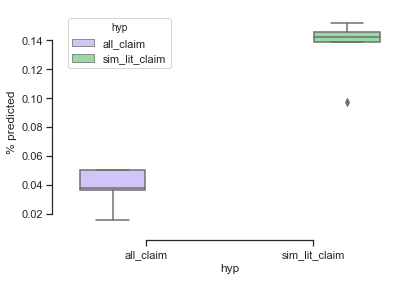

In [289]:
import seaborn as sns
sns.set(style="ticks", palette="pastel")

sns.boxplot(x="hyp", y="% predicted",
             hue='hyp',palette=["m", "g"],
            data=experiments)
sns.despine(offset=10, trim=True)


In [275]:
# Factor of increase in PREDICTABILITY using similarity
pd.DataFrame({
    'Model' : models_names,
    'Factor' : results_01['% predicted']/results_ac['% predicted']
                                                    })


,Model,Factor
0,ICL_ICC_100F,2.766785
1,ICL_100F,4.025642
2,ICC_100F,2.873161
3,100F,3.935616
4,ICL_ICC,6.262534


In [310]:
# Factor of data decrease & increase in predictability
pr = len(df_gbd)/len(ddf)*100 # percent reduced
fp =  results_01['% predicted'].max()/results_ac['% predicted'].max() # increase in predictability
print(f' The dataset has been reduced to {round(pr,2)}% of its original size,','\n',f'while increasing the ability to predict litigation by a factor of {round(fp,2)}')



 The dataset has been reduced to 2.5% of its original size, 
 while increasing the ability to predict litigation by a factor of 3.0
